In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/web-traffic-time-series-forecasting/sample_submission_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/sample_submission_1.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/train_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/key_1.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/key_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
from collections import Counter
%matplotlib inline

from tqdm import tnrange
import seaborn as sns
import re
from statsmodels.graphics.tsaplots import plot_acf
from scipy.signal import periodogram
import datetime
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,normalize

In [3]:
data = pd.read_csv("/kaggle/input/web-traffic-time-series-forecasting/train_2.csv.zip", compression = "zip")
data.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  ...  2017-09-01  2017-09-02  2017-09-03  2017-09-04  \
0        26.0  ...        19.0        33.0        33.0        18.0   
1        10.0  ...        32.0        30.0        11.0        19.0   
2         4.0  ...         6.0         6.0         7.0         2.0   
3        11.0  ...         7.0        19.0        19.0         9.0   
4         NaN  ...        16.0        16.0        19.0         9.0   

   2017-09-05  2017-09-06  2017-09-07  2017-09-08  2017-09-09  2017-09-10  
0        16.0        27.0        29.0        23.0        54.0        38.0  
1        54.0        25.0        26.0        23.0        13.0        81.0  
2         4.0         7.0         3.0         4.0         7.0         6.0  
3         6.0        16.0        19.0        30.0        38.0         4.0  
4        20.0        23.0        28.0        14.0         8.0         7.0  

[5 rows x 804 columns]

In [4]:
data.isna().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2017-09-06     1775
2017-09-07     3467
2017-09-08     1061
2017-09-09     3332
2017-09-10     5578
Length: 804, dtype: int64

Observing the dataset, it becomes evident that there are numerous missing values. In certain instances, data is available exclusively for the most recent months, with the remaining duration showing null values. One plausible explanation for this pattern is that the wiki page might have been created at a later date, resulting in data being recorded only for the days following the page's creation.

In [5]:
Page=data['Page']

In [6]:
data=data.drop(columns=['Page']).interpolate(axis=1)

In [7]:
data.isna().sum()

2015-07-01    20740
2015-07-02    19767
2015-07-03    19256
2015-07-04    18983
2015-07-05    18818
              ...  
2017-09-06        0
2017-09-07        0
2017-09-08        0
2017-09-09        0
2017-09-10        0
Length: 803, dtype: int64

At this point, the remaining missing values in our dataset appear to correspond to periods of consecutive days, possibly extending to months. Based on this observation, we infer that the absence of data during these periods signifies that the respective wiki pages might not have been created at that time. Consequently, we have decided to impute these missing values with zeros, considering them as instances where the page was not yet in existence.

In [8]:
data.fillna(0,inplace=True)

In [9]:
data.isna().sum()

2015-07-01    0
2015-07-02    0
2015-07-03    0
2015-07-04    0
2015-07-05    0
             ..
2017-09-06    0
2017-09-07    0
2017-09-08    0
2017-09-09    0
2017-09-10    0
Length: 803, dtype: int64

In [10]:
data.insert(loc=0,column='Page',value=Page)

In [11]:
data.shape

(145063, 804)

In [12]:
data.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         0.0         0.0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   2015-07-09  ...  2017-09-01  2017-09-02  2017-09-03  2017-09-04  \
0        26.0  ...        19.0        33.0        33.0        18.0   
1        10.0  ...        32.0        30.0        11.0        19.0   
2         4.0  ...         6.0         6.0         7.0         2.0   
3        11.0  ...         7.0        19.0        19.0         9.0   
4         0.0  ...        16.0        16.0        19.0         9.0   

   2017-09-05  2017-09-06  2017-09-07  2017-09-08  2017-09-09  2017-09-10  
0        16.0        27.0        29.0        23.0        54.0        38.0  
1        54.0        25.0        26.0        23.0        13.0        81.0  
2         4.0         7.0         3.0         4.0         7.0         6.0  
3         6.0        16.0        19.0        30.0        38.0         4.0  
4        20.0        23.0        28.0        14.0         8.0         7.0  

[5 rows x 804 columns]

# Converting to time series format :

In [13]:
# Interchanging Rows and Column of data to get it in proper time series format
data = data.T
data.head()

0       \
Page        2NE1_zh.wikipedia.org_all-access_spider   
2015-07-01                                     18.0   
2015-07-02                                     11.0   
2015-07-03                                      5.0   
2015-07-04                                     13.0   

                                            1       \
Page        2PM_zh.wikipedia.org_all-access_spider   
2015-07-01                                    11.0   
2015-07-02                                    14.0   
2015-07-03                                    15.0   
2015-07-04                                    18.0   

                                           2       \
Page        3C_zh.wikipedia.org_all-access_spider   
2015-07-01                                    1.0   
2015-07-02                                    0.0   
2015-07-03                                    1.0   
2015-07-04                                    1.0   

                                                3       \
Page        4minute_zh.wikipedia.org_all-access_spider   
2015-07-01                                        35.0   
2015-07-02                                        13.0   
2015-07-03                                        10.0   
2015-07-04                                        94.0   

                                                       4       \
Page        52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...   
2015-07-01                                                0.0   
2015-07-02                                                0.0   
2015-07-03                                                0.0   
2015-07-04                                                0.0   

                                             5       \
Page        5566_zh.wikipedia.org_all-access_spider   
2015-07-01                                     12.0   
2015-07-02                                      7.0   
2015-07-03                                      4.0   
2015-07-04                                      5.0   

                                               6       \
Page        91Days_zh.wikipedia.org_all-access_spider   
2015-07-01                                        0.0   
2015-07-02                                        0.0   
2015-07-03                                        0.0   
2015-07-04                                        0.0   

                                              7       \
Page        A'N'D_zh.wikipedia.org_all-access_spider   
2015-07-01                                     118.0   
2015-07-02                                      26.0   
2015-07-03                                      30.0   
2015-07-04                                      24.0   

                                              8       \
Page        AKB48_zh.wikipedia.org_all-access_spider   
2015-07-01                                       5.0   
2015-07-02                                      23.0   
2015-07-03                                      14.0   
2015-07-04                                      12.0   

                                              9       ...  \
Page        ASCII_zh.wikipedia.org_all-access_spider  ...   
2015-07-01                                       6.0  ...   
2015-07-02                                       3.0  ...   
2015-07-03                                       5.0  ...   
2015-07-04                                      12.0  ...   

                                                       145053  \
Page        Drake_(músico)_es.wikipedia.org_all-access_spider   
2015-07-01                                                0.0   
2015-07-02                                                0.0   
2015-07-03                                                0.0   
2015-07-04                                                0.0   

                                                       145054  \
Page        Skam_(serie_de_televisión)_es.wikipedia.org_al...   
2015-07-01                                                0.0   
2015-07-02                   

In [14]:
data = data.reset_index()
data.head()

index                                        0  \
0        Page  2NE1_zh.wikipedia.org_all-access_spider   
1  2015-07-01                                     18.0   
2  2015-07-02                                     11.0   
3  2015-07-03                                      5.0   
4  2015-07-04                                     13.0   

                                        1  \
0  2PM_zh.wikipedia.org_all-access_spider   
1                                    11.0   
2                                    14.0   
3                                    15.0   
4                                    18.0   

                                       2  \
0  3C_zh.wikipedia.org_all-access_spider   
1                                    1.0   
2                                    0.0   
3                                    1.0   
4                                    1.0   

                                            3  \
0  4minute_zh.wikipedia.org_all-access_spider   
1                                        35.0   
2                                        13.0   
3                                        10.0   
4                                        94.0   

                                                   4  \
0  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   

                                         5  \
0  5566_zh.wikipedia.org_all-access_spider   
1                                     12.0   
2                                      7.0   
3                                      4.0   
4                                      5.0   

                                           6  \
0  91Days_zh.wikipedia.org_all-access_spider   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

                                          7  \
0  A'N'D_zh.wikipedia.org_all-access_spider   
1                                     118.0   
2                                      26.0   
3                                      30.0   
4                                      24.0   

                                          8  ...  \
0  AKB48_zh.wikipedia.org_all-access_spider  ...   
1                                       5.0  ...   
2                                      23.0  ...   
3                                      14.0  ...   
4                                      12.0  ...   

                                              145053  \
0  Drake_(músico)_es.wikipedia.org_all-access_spider   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   

                                              145054  \
0  Skam_(serie_de_televisión)_es.wikipedia.org_al...   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   

                                              145055  \
0  Legión_(serie_de_televisión)_es.wikipedia.org_...   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   

                                              145056  \
0  Doble_tentación_es.wikipedia.org_all-access_sp...   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                     

In [15]:
# Making the 1st row column header
column_header = data.iloc[0,:].values
data.columns = column_header

data = data.drop(0, axis = 0)

data.head()

Page 2NE1_zh.wikipedia.org_all-access_spider  \
1  2015-07-01                                    18.0   
2  2015-07-02                                    11.0   
3  2015-07-03                                     5.0   
4  2015-07-04                                    13.0   
5  2015-07-05                                    14.0   

  2PM_zh.wikipedia.org_all-access_spider  \
1                                   11.0   
2                                   14.0   
3                                   15.0   
4                                   18.0   
5                                   11.0   

  3C_zh.wikipedia.org_all-access_spider  \
1                                   1.0   
2                                   0.0   
3                                   1.0   
4                                   1.0   
5                                   0.0   

  4minute_zh.wikipedia.org_all-access_spider  \
1                                       35.0   
2                                       13.0   
3                                       10.0   
4                                       94.0   
5                                        4.0   

  52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider  \
1                                                0.0    
2                                                0.0    
3                                                0.0    
4                                                0.0    
5                                                0.0    

  5566_zh.wikipedia.org_all-access_spider  \
1                                    12.0   
2                                     7.0   
3                                     4.0   
4                                     5.0   
5                                    20.0   

  91Days_zh.wikipedia.org_all-access_spider  \
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
5                                       0.0   

  A'N'D_zh.wikipedia.org_all-access_spider  \
1                                    118.0   
2                                     26.0   
3                                     30.0   
4                                     24.0   
5                                     29.0   

  AKB48_zh.wikipedia.org_all-access_spider  ...  \
1                                      5.0  ...   
2                                     23.0  ...   
3                                     14.0  ...   
4                                     12.0  ...   
5                                      9.0  ...   

  Drake_(músico)_es.wikipedia.org_all-access_spider  \
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   
5                                               0.0   

  Skam_(serie_de_televisión)_es.wikipedia.org_all-access_spider  \
1                                                0.0              
2                                                0.0              
3                                                0.0              
4                                                0.0              
5                                                0.0              

  Legión_(serie_de_televisión)_es.wikipedia.org_all-access_spider  \
1                                                0.0                
2                                                0.0                
3                                                0.0                
4                                                0.0                
5                                                0.0                

  Doble_tentación_es.wikipedia.org_all-access_spider  \
1                                                0.0   
2                                                0.0   
3                                                0.0   

In [16]:
data = data.rename(columns = {"Page" : "Date"})
data.head()

Date 2NE1_zh.wikipedia.org_all-access_spider  \
1  2015-07-01                                    18.0   
2  2015-07-02                                    11.0   
3  2015-07-03                                     5.0   
4  2015-07-04                                    13.0   
5  2015-07-05                                    14.0   

  2PM_zh.wikipedia.org_all-access_spider  \
1                                   11.0   
2                                   14.0   
3                                   15.0   
4                                   18.0   
5                                   11.0   

  3C_zh.wikipedia.org_all-access_spider  \
1                                   1.0   
2                                   0.0   
3                                   1.0   
4                                   1.0   
5                                   0.0   

  4minute_zh.wikipedia.org_all-access_spider  \
1                                       35.0   
2                                       13.0   
3                                       10.0   
4                                       94.0   
5                                        4.0   

  52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider  \
1                                                0.0    
2                                                0.0    
3                                                0.0    
4                                                0.0    
5                                                0.0    

  5566_zh.wikipedia.org_all-access_spider  \
1                                    12.0   
2                                     7.0   
3                                     4.0   
4                                     5.0   
5                                    20.0   

  91Days_zh.wikipedia.org_all-access_spider  \
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
5                                       0.0   

  A'N'D_zh.wikipedia.org_all-access_spider  \
1                                    118.0   
2                                     26.0   
3                                     30.0   
4                                     24.0   
5                                     29.0   

  AKB48_zh.wikipedia.org_all-access_spider  ...  \
1                                      5.0  ...   
2                                     23.0  ...   
3                                     14.0  ...   
4                                     12.0  ...   
5                                      9.0  ...   

  Drake_(músico)_es.wikipedia.org_all-access_spider  \
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   
5                                               0.0   

  Skam_(serie_de_televisión)_es.wikipedia.org_all-access_spider  \
1                                                0.0              
2                                                0.0              
3                                                0.0              
4                                                0.0              
5                                                0.0              

  Legión_(serie_de_televisión)_es.wikipedia.org_all-access_spider  \
1                                                0.0                
2                                                0.0                
3                                                0.0                
4                                                0.0                
5                                                0.0                

  Doble_tentación_es.wikipedia.org_all-access_spider  \
1                                                0.0   
2                                                0.0   
3                                                0.0   

In [17]:
# Convert Date column to datetime datatype
data["Date"] = pd.to_datetime(data["Date"])

In [18]:
# Set Date column as index
data = data.set_index("Date")
data.head()

2NE1_zh.wikipedia.org_all-access_spider  \
Date                                                 
2015-07-01                                    18.0   
2015-07-02                                    11.0   
2015-07-03                                     5.0   
2015-07-04                                    13.0   
2015-07-05                                    14.0   

           2PM_zh.wikipedia.org_all-access_spider  \
Date                                                
2015-07-01                                   11.0   
2015-07-02                                   14.0   
2015-07-03                                   15.0   
2015-07-04                                   18.0   
2015-07-05                                   11.0   

           3C_zh.wikipedia.org_all-access_spider  \
Date                                               
2015-07-01                                   1.0   
2015-07-02                                   0.0   
2015-07-03                                   1.0   
2015-07-04                                   1.0   
2015-07-05                                   0.0   

           4minute_zh.wikipedia.org_all-access_spider  \
Date                                                    
2015-07-01                                       35.0   
2015-07-02                                       13.0   
2015-07-03                                       10.0   
2015-07-04                                       94.0   
2015-07-05                                        4.0   

           52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider  \
Date                                                             
2015-07-01                                                0.0    
2015-07-02                                                0.0    
2015-07-03                                                0.0    
2015-07-04                                                0.0    
2015-07-05                                                0.0    

           5566_zh.wikipedia.org_all-access_spider  \
Date                                                 
2015-07-01                                    12.0   
2015-07-02                                     7.0   
2015-07-03                                     4.0   
2015-07-04                                     5.0   
2015-07-05                                    20.0   

           91Days_zh.wikipedia.org_all-access_spider  \
Date                                                   
2015-07-01                                       0.0   
2015-07-02                                       0.0   
2015-07-03                                       0.0   
2015-07-04                                       0.0   
2015-07-05                                       0.0   

           A'N'D_zh.wikipedia.org_all-access_spider  \
Date                                                  
2015-07-01                                    118.0   
2015-07-02                                     26.0   
2015-07-03                                     30.0   
2015-07-04                                     24.0   
2015-07-05                                     29.0   

           AKB48_zh.wikipedia.org_all-access_spider  \
Date                                                  
2015-07-01                                      5.0   
2015-07-02                                     23.0   
2015-07-03                                     14.0   
2015-07-04                                     12.0   
2015-07-05                                      9.0   

           ASCII_zh.wikipedia.org_all-access_spider  ...  \
Date                                                 ...   
2015-07-01                                      6.0  ...   
2015-07-02                                      3.0  ...   
2015-07-03                                      5.0  ...   
2015-07-04                                     12.0  ...   
2015-07-05                                      6.0  ...   

           Drake_(músico)_es.wikipedia.org_all-access_spider  \
Dat

# Exploratory Data Analysis

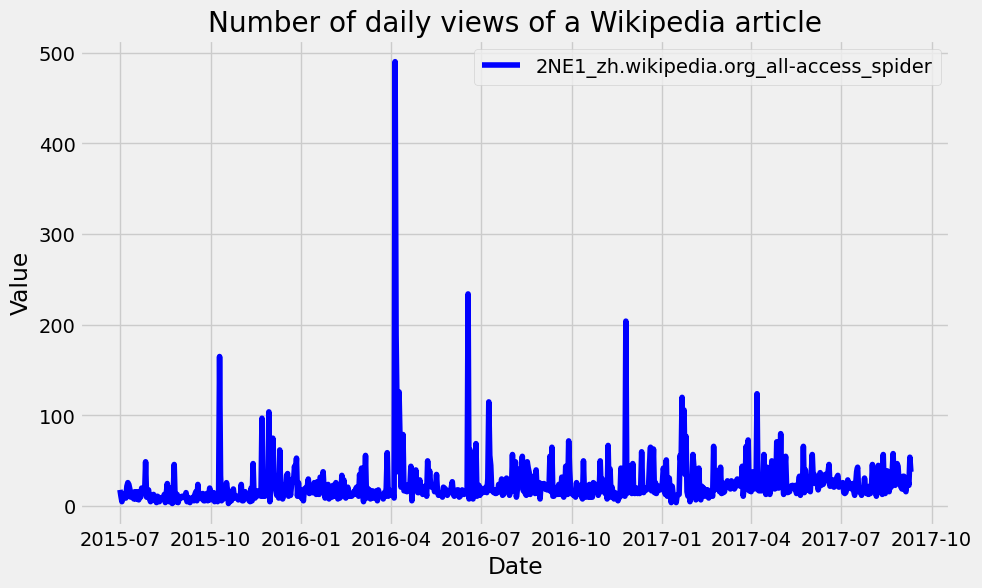

In [19]:
plt.figure(figsize=(10, 6))

plt.plot(data.index, data.iloc[:, 0], label=data.columns[0], color='blue')

plt.title('Number of daily views of a Wikipedia article')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

## Analysis based on spider and human accesses

In [20]:
data_transposed = data.transpose()

agent_data_list = []
agent_number = [0, 0]

# Initialize agent_data_list with zeros
for i in range(2):
    agent_data_list.append(np.zeros(data_transposed.shape[1] - 1))

# This will make two time series from the transposed dataset, one for the total traffic by spider and the other for non-spider
for i in tnrange(len(Page)):
    add_list = data_transposed.iloc[i].values[1:]
    if 'spider' in Page[i]:
        agent_data_list[0] = list(map(np.add, agent_data_list[0], add_list))
        agent_number[0] += 1
    else:
        agent_data_list[1] = list(map(np.add, agent_data_list[1], add_list))
        agent_number[1] += 1

/tmp/ipykernel_42/2560230012.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(Page)):


  0%|          | 0/145063 [00:00<?, ?it/s]

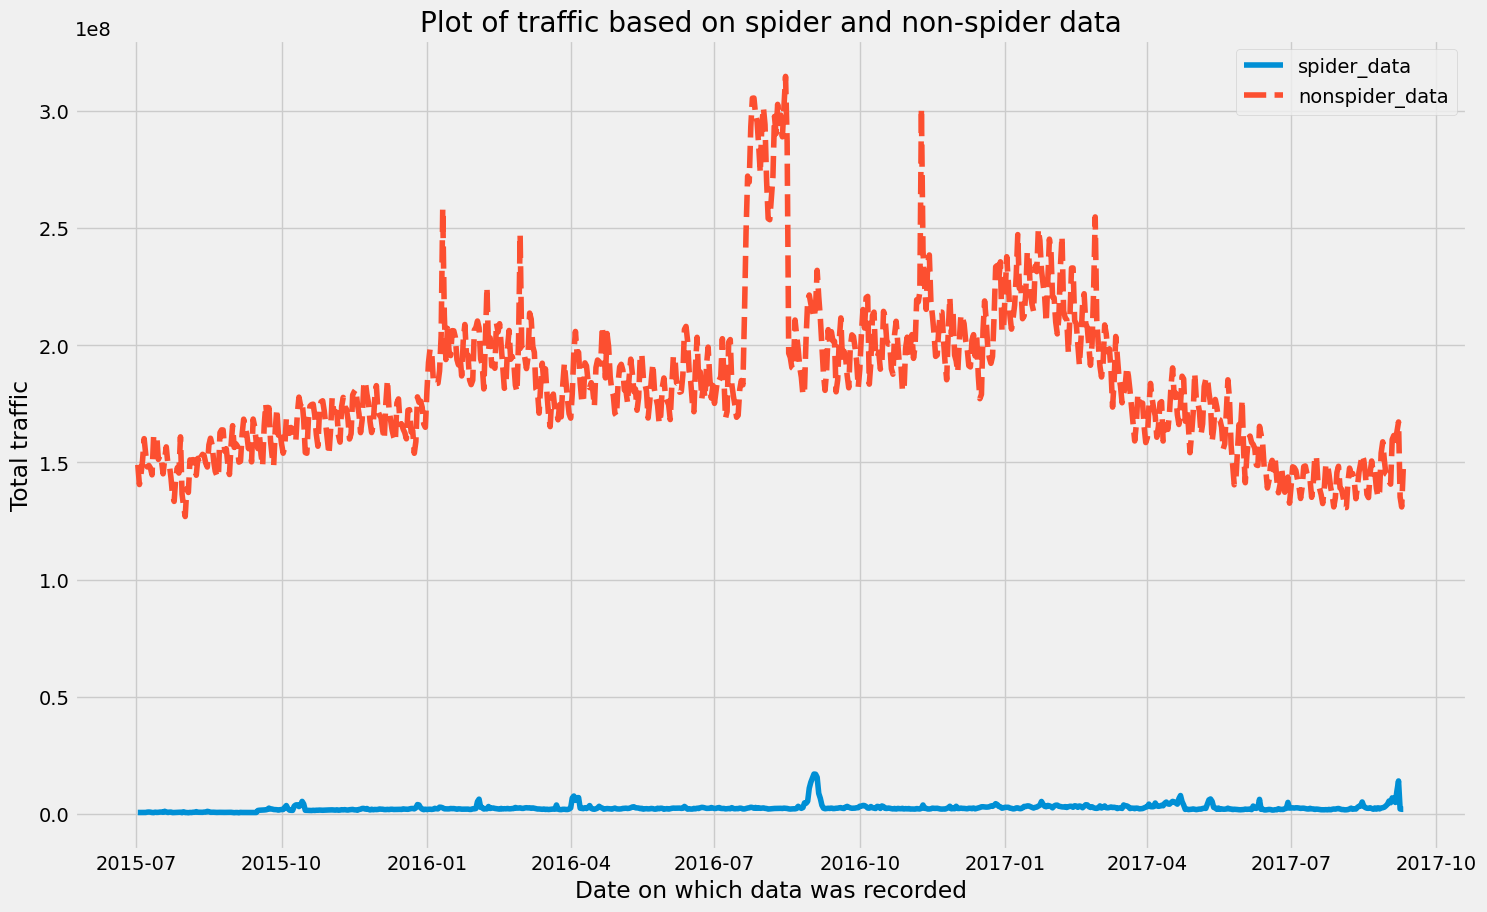

In [21]:
new_data = pd.DataFrame(agent_data_list, index=['spider_data', 'nonspider_data'], columns=data_transposed.columns.values[1:])
plt.figure(figsize=(16, 10))
sns.lineplot(data=new_data.transpose())
plt.title('Plot of traffic based on spider and non-spider data')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Total traffic')
plt.show()

The observed plot reveals a distinct pattern in the non-spider data, while the spider data appears nearly as a flat line. This discrepancy suggests a significant difference in scale between the spider and non-spider datasets. The flat line in the spider data, contrary to expectations, may indicate that the traffic attributed to spiders is comparatively lower or distributed differently over the recorded dates.

In [22]:
print('Median of nonspider data is : ',np.median(new_data.transpose().nonspider_data))
print('Median of spider data is : ',np.median(new_data.transpose().spider_data))

Median of nonspider data is :  180467731.8325861
Median of spider data is :  2293278.9775829827


The observed discrepancy between spider and non-spider data, differing at a scale of 10^2, is substantial. This stark difference may be attributed to the prevalent practice of directly accessing Wikipedia pages for information needs, as opposed to utilizing web scraping or web crawling techniques. Typically, web scraping is employed when extracting a large volume of data in a batch process, whereas direct access is favored for individual information retrieval from Wikipedia pages.

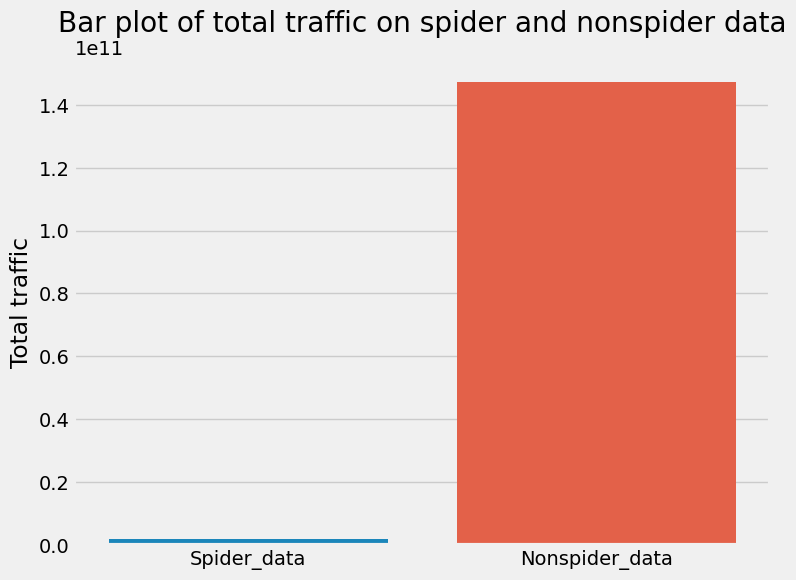

In [23]:
total_spider_traffic = new_data.transpose()['spider_data'].sum()
total_nonspider_traffic = new_data.transpose()['nonspider_data'].sum()

plt.figure(figsize=(8, 6))
sns.barplot(x=['Spider_data', 'Nonspider_data'], y=[total_spider_traffic, total_nonspider_traffic])
plt.title('Bar plot of total traffic on spider and nonspider data')
plt.ylabel('Total traffic')
plt.show()

The plot vividly illustrates that the total traffic attributed to spider data is nearly negligible when compared to the non-spider data.

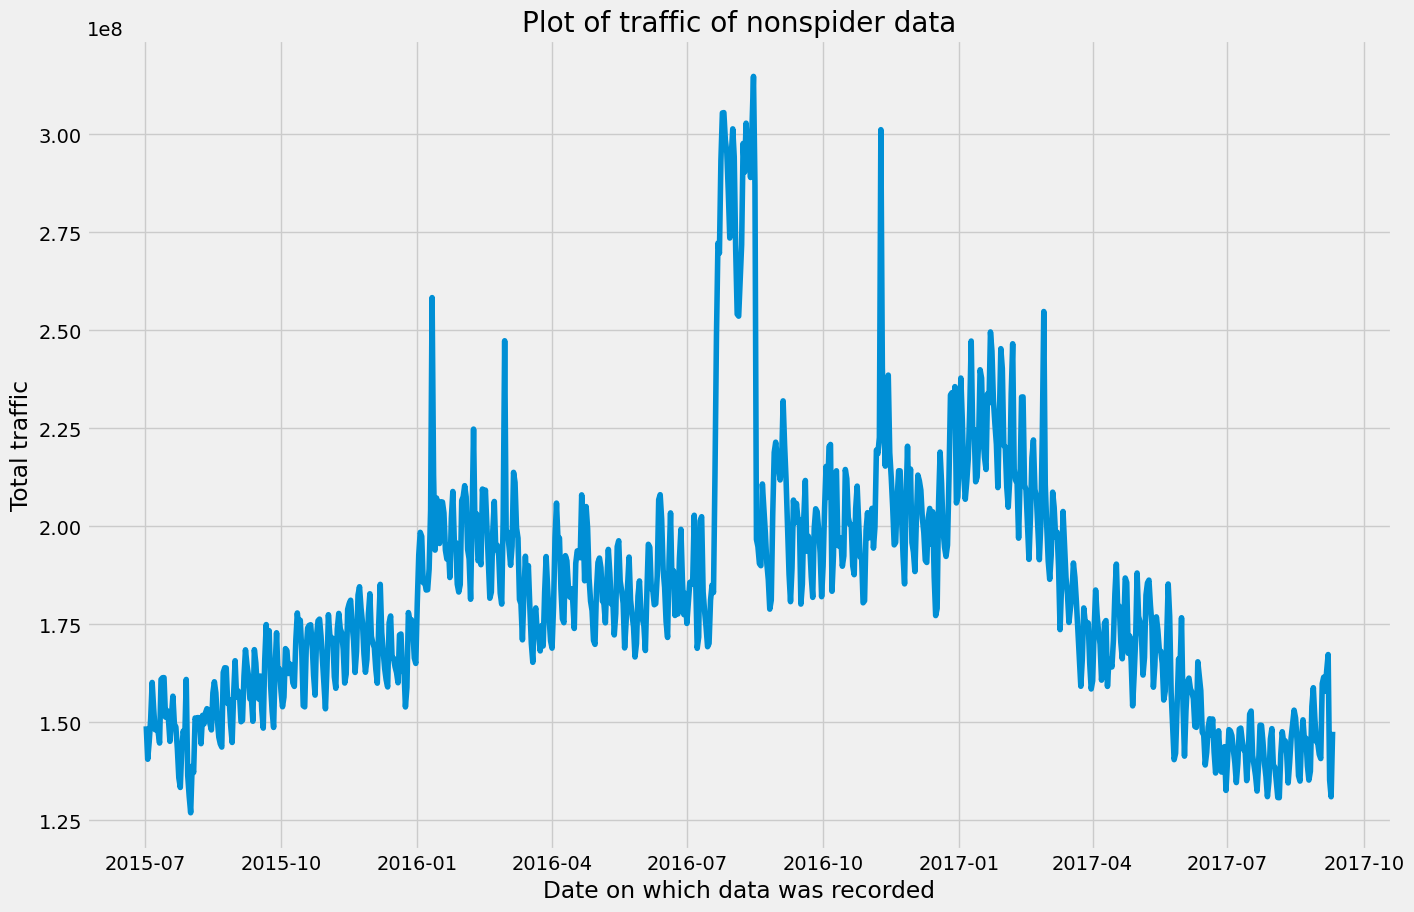

In [24]:
nonspider_data_series = new_data.loc['nonspider_data']

plt.figure(figsize=(15, 10))
sns.lineplot(data=nonspider_data_series)
plt.title('Plot of traffic of nonspider data')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Total traffic')
plt.show()

The plot reveals distinct patterns in the non-spider data over the recorded period. Notably, there is an initial upward trend in the first few months, followed by a subsequent downward trend in the last few months. Additionally, a noticeable pattern emerges during January 2016, while the data exhibits a substantial spike in August 2016 and another notable increase in November 2016. These observations suggest varying trends and noteworthy events within the dataset during specific time frames.

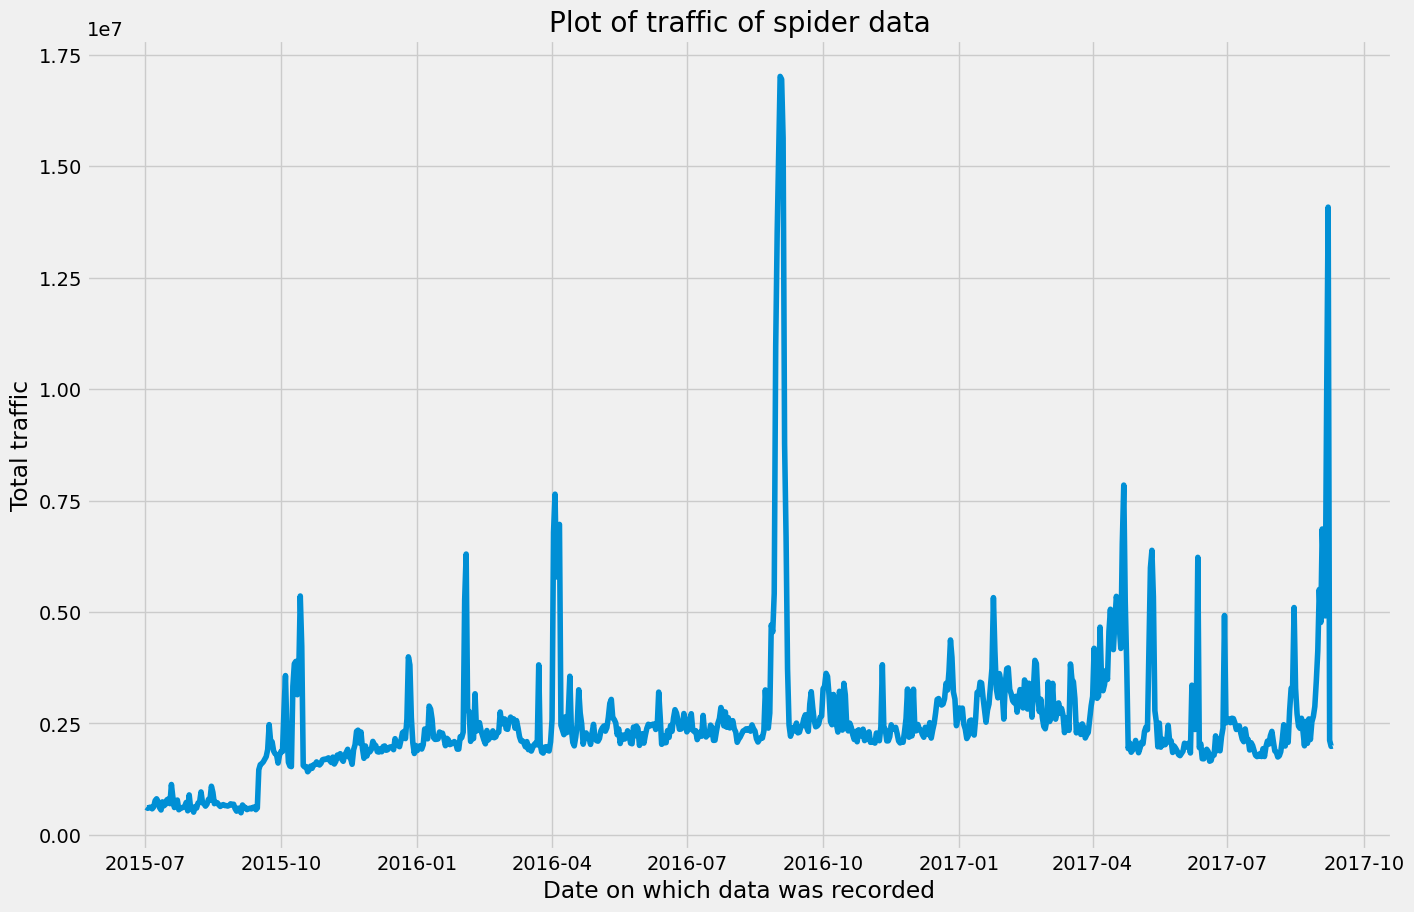

In [25]:
spider_data_series = new_data.loc['spider_data']

plt.figure(figsize=(15, 10))
sns.lineplot(data=spider_data_series)
plt.title('Plot of traffic of spider data')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Total traffic')
plt.show()

The plot indicates a lack of a discernible upward or downward trend in spider data over time. However, it does highlight a noticeable shift in traffic scale, with an apparent increase post-September 2015. The presence of regular spikes in the data is evident, and two particularly significant spikes stand out during September 2016 and September 2015, suggesting noteworthy events or changes in data patterns during these periods.

In conclusion, the predominant portion of the dataset comprises non-spider data.

## Analysis based on different projects

In [26]:
projects = [column.split("_")[-3] for column in data.columns]
project_dict = Counter(projects)
projects = [column.split("_")[-3] for column in data.columns]
project_dict = Counter(projects)
project_data = pd.DataFrame(project_dict.items(), columns=["Project", "Number of columns"])
project_data

Project  Number of columns
0       zh.wikipedia.org              17229
1       fr.wikipedia.org              17802
2       en.wikipedia.org              24108
3  commons.wikimedia.org              10555
4       ru.wikipedia.org              15022
5      www.mediawiki.org               7300
6       de.wikipedia.org              18547
7       ja.wikipedia.org              20431
8       es.wikipedia.org              14069

In [27]:
def extract_total_views(project):
    required_column_names = [column for column in data.columns if project in column]
    total_views = data[required_column_names].sum().sum()
    return total_views

total_views = [extract_total_views(project) for project in project_data["Project"]]

project_data["Total views"] = total_views
project_data

Project  Number of columns   Total views
0       zh.wikipedia.org              17229  4.676514e+09
1       fr.wikipedia.org              17802  8.998247e+09
2       en.wikipedia.org              24108  8.423276e+10
3  commons.wikimedia.org              10555  1.690923e+09
4       ru.wikipedia.org              15022  1.104003e+10
5      www.mediawiki.org               7300  3.985946e+08
6       de.wikipedia.org              18547  1.252788e+10
7       ja.wikipedia.org              20431  1.215321e+10
8       es.wikipedia.org              14069  1.358495e+10

In [28]:
def extract_average_views(project):
    required_column_names = [column for column in data.columns if project in column]
    average_views = data[required_column_names].sum().mean()
    return average_views

average_views = [extract_average_views(project) for project in project_data["Project"]]

average_views

[271432.70584479655,
 505462.7128693405,
 3493975.380890161,
 160201.09369966842,
 734924.4329317001,
 54602.00020547945,
 675466.4152423573,
 594841.7448729872,
 965594.4084156656]

In [29]:
project_data['Total views'] = project_data['Total views'].astype('int64')
project_data["Average views"] = average_views
project_data['Average views'] = project_data['Average views'].astype('int64')
project_data_sorted = project_data.sort_values(by = "Average views", ascending = False)
project_data_sorted

Project  Number of columns  Total views  Average views
2       en.wikipedia.org              24108  84232758482        3493975
8       es.wikipedia.org              14069  13584947732         965594
4       ru.wikipedia.org              15022  11040034831         734924
6       de.wikipedia.org              18547  12527875603         675466
7       ja.wikipedia.org              20431  12153211689         594841
1       fr.wikipedia.org              17802   8998247214         505462
0       zh.wikipedia.org              17229   4676514089         271432
3  commons.wikimedia.org              10555   1690922544         160201
5      www.mediawiki.org               7300    398594601          54602

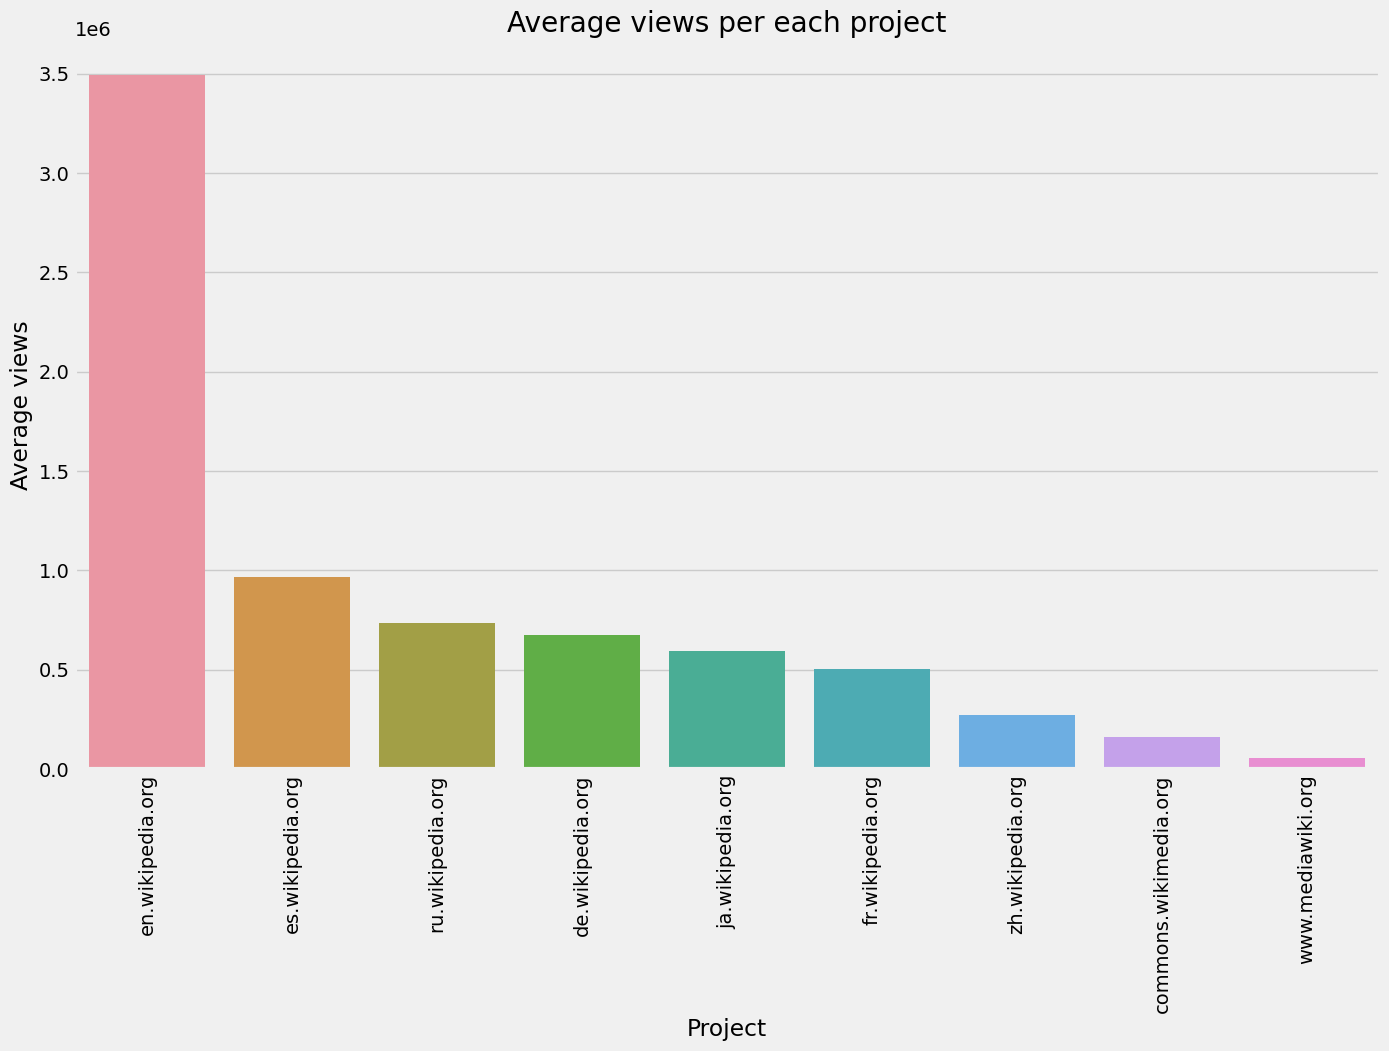

In [30]:
plt.figure(figsize = (15,9))
sns.barplot(x = project_data_sorted["Project"], y = project_data_sorted["Average views"])
plt.xticks(rotation = "vertical")
plt.title("Average views per each project")
plt.show()

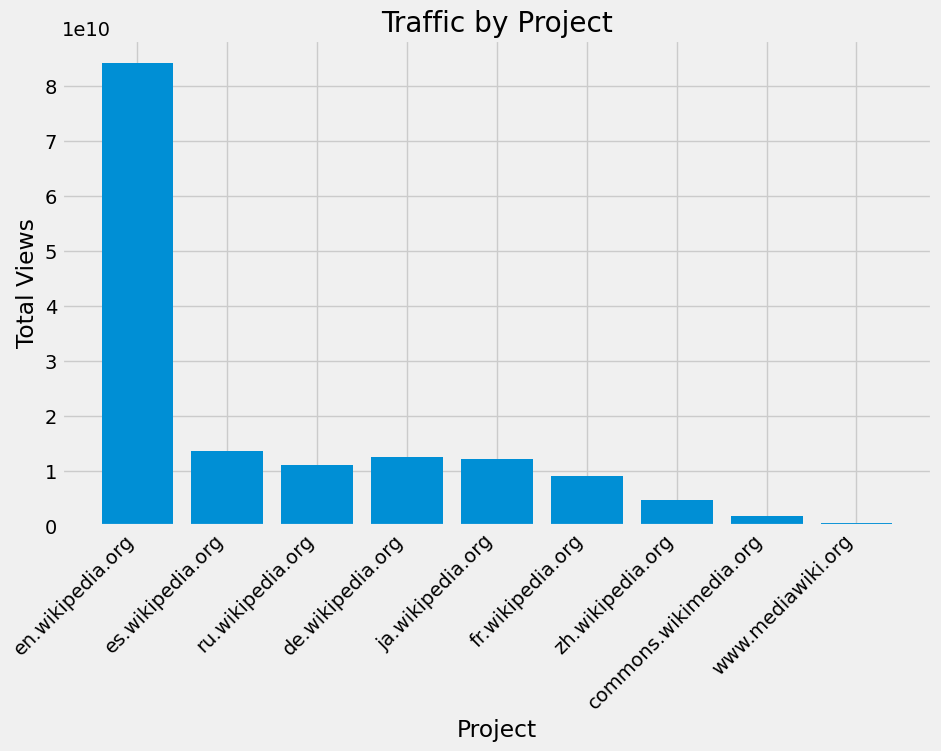

In [31]:
plt.figure(figsize=(10, 6))
plt.bar(project_data_sorted["Project"], project_data_sorted["Total views"])
plt.title("Traffic by Project")
plt.xlabel("Project")
plt.ylabel("Total Views")
plt.xticks(rotation=45, ha="right") 
plt.show()

### Popular pages in "en.wikipedia.org"

<Axes: xlabel='Date'>

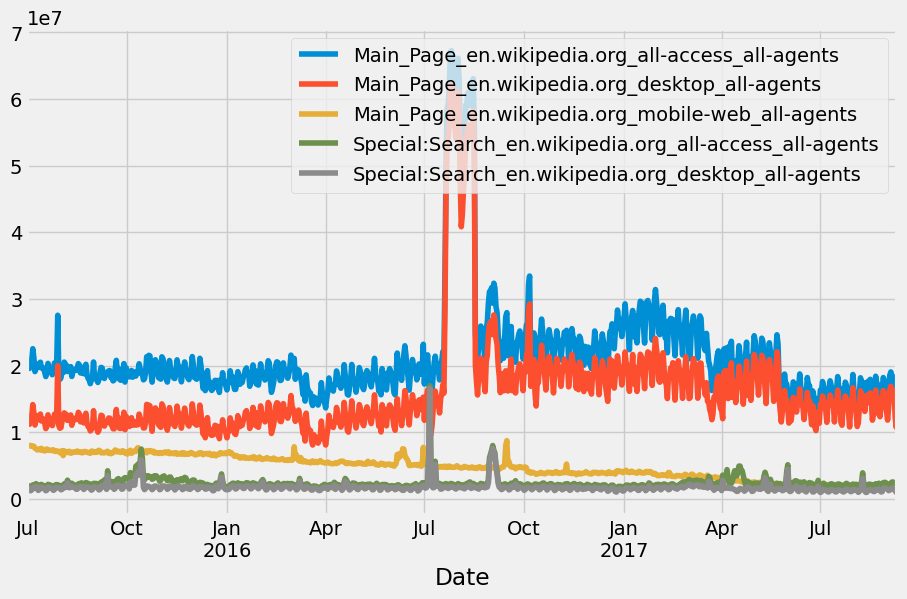

In [32]:
en_wikipedia_org_columns = data.filter(like="en.wikipedia.org")

# Calculating the mean values for each page and sorting
top_pages_en = en_wikipedia_org_columns.mean().sort_values(ascending=False).head(5)

# Plotting the top 5 pages
data[top_pages_en.index].plot(figsize=(10, 6))

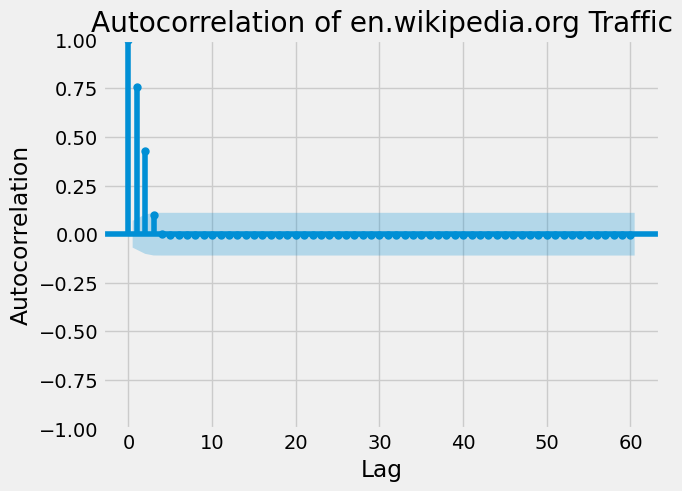

In [33]:
# Find the column that contains "en.wikipedia.org"
target_column = [col for col in en_wikipedia_org_columns.columns if "en.wikipedia.org" in col]

en_wikipedia_traffic = en_wikipedia_org_columns[target_column[0]]

# Plot autocorrelation
plot_acf(en_wikipedia_traffic, lags=60)  # A lag is a day
plt.title("Autocorrelation of en.wikipedia.org Traffic")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

No weekly seasoning

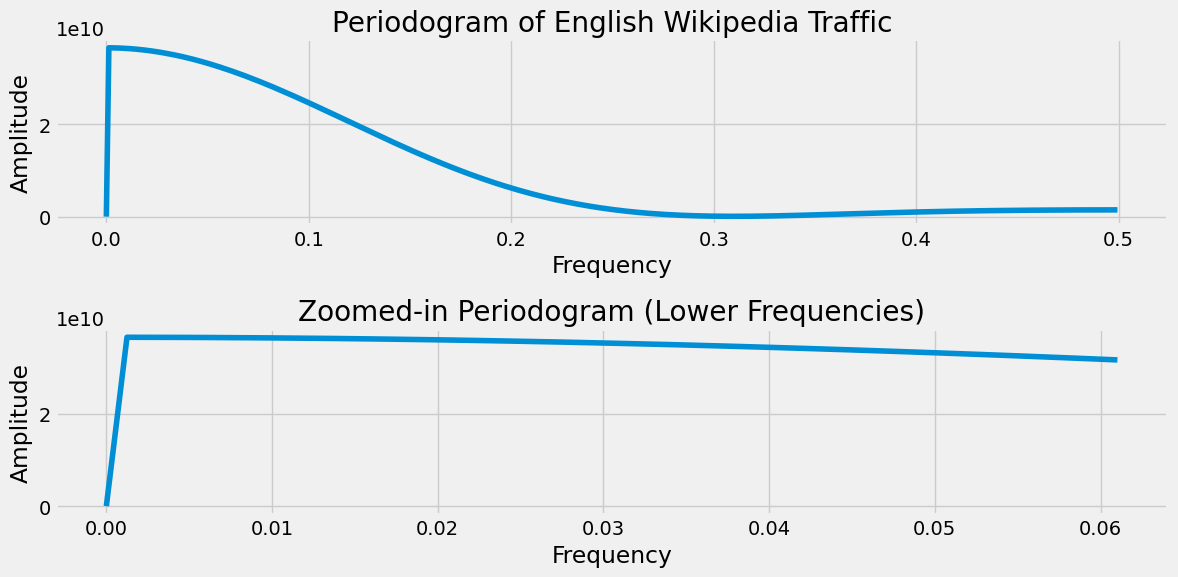

In [34]:
traffic_values = en_wikipedia_traffic.values
time_index = np.arange(len(traffic_values))

# Calculate the periodogram
frequencies, amplitudes = periodogram(traffic_values)

# Use absolute values to handle complex numbers
amplitudes = np.abs(amplitudes)

# Plot the frequency and amplitude
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(frequencies, amplitudes)
plt.title('Periodogram of English Wikipedia Traffic')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
# Zoom in on lower frequencies for a clearer view
plt.plot(frequencies[:50], amplitudes[:50])
plt.title('Zoomed-in Periodogram (Lower Frequencies)')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

**Indication : ***

Frequency and Amplitude Plot:

X-Axis (Frequency): Represents different frequencies present in the signal. The frequency is measured in cycles per unit of time (e.g., cycles per day). Period(days) = 1/frequency

Y-Axis (Amplitude): Represents the strength or magnitude of each frequency component in the signal.
Interpretation:

Peaks in the amplitude indicate dominant frequencies in the signal.
Higher peaks suggest stronger periodicities.
Zoomed-in Plot (Lower Frequencies):

This plot is a closer look at the lower frequencies for a clearer view.
Interpretation:

Observe any prominent peaks in the amplitude, especially at lower frequencies.
Dominant peaks may indicate significant periodicities.

Conclusion : The identified peaks in the periodogram doesn't show any specific pattern

### Popular pages in "es.wikipedia.org"

<Axes: xlabel='Date'>

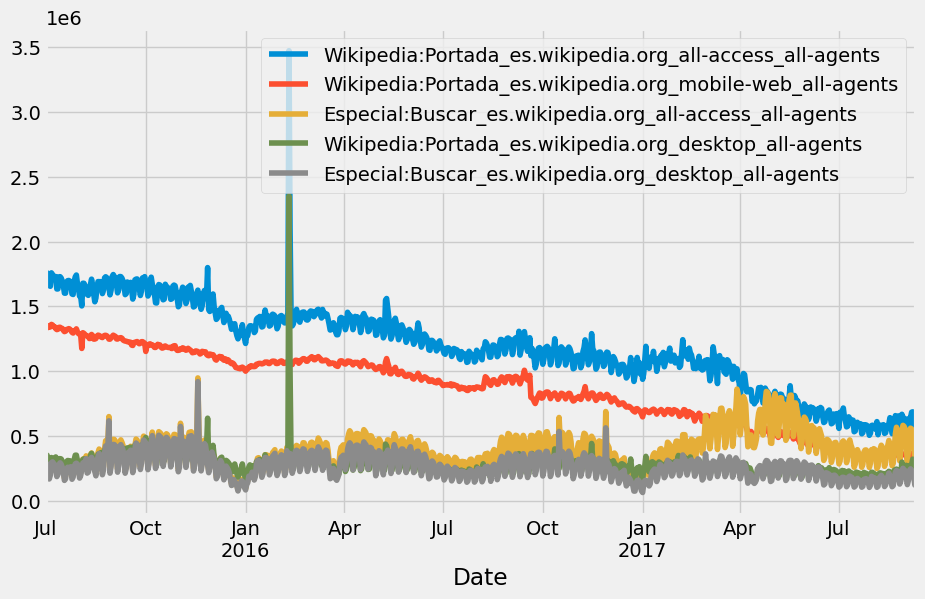

In [35]:
es_wikipedia_org_columns = data.filter(like="es.wikipedia.org")

# Calculating the mean values for each page and sorting
top_pages_es = es_wikipedia_org_columns.mean().sort_values(ascending=False).head(5)

# Plotting the top 5 pages
data[top_pages_es.index].plot(figsize=(10, 6))

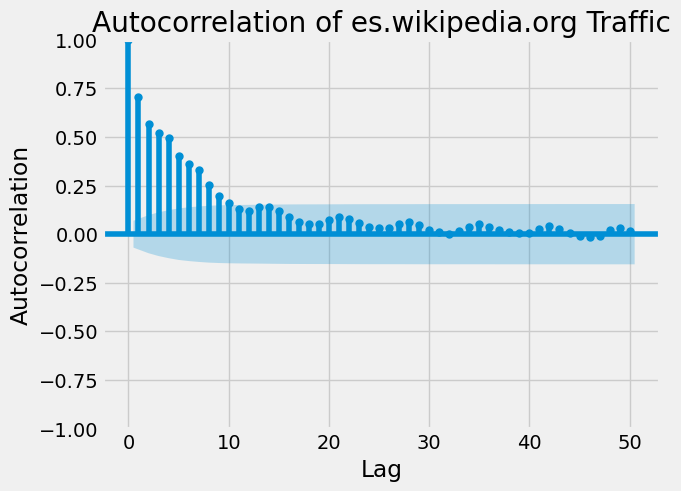

In [36]:
# Find the column that contains "es.wikipedia.org"
target_column = [col for col in es_wikipedia_org_columns.columns if "es.wikipedia.org" in col]

es_wikipedia_traffic = es_wikipedia_org_columns[target_column[0]]

# Plot autocorrelation
plot_acf(es_wikipedia_traffic, lags=50)  # A lag is a day
plt.title("Autocorrelation of es.wikipedia.org Traffic")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

The autocorrelation plot reveals a significant correlation value at a lag of 7 days, indicating a recurring weekly trend in the data.

Conclusion: Based on this observation, we can infer that incorporating a lag of 7 days in our Autoregressive (AR) model can yield accurate predictions for the Spanish language dataset.

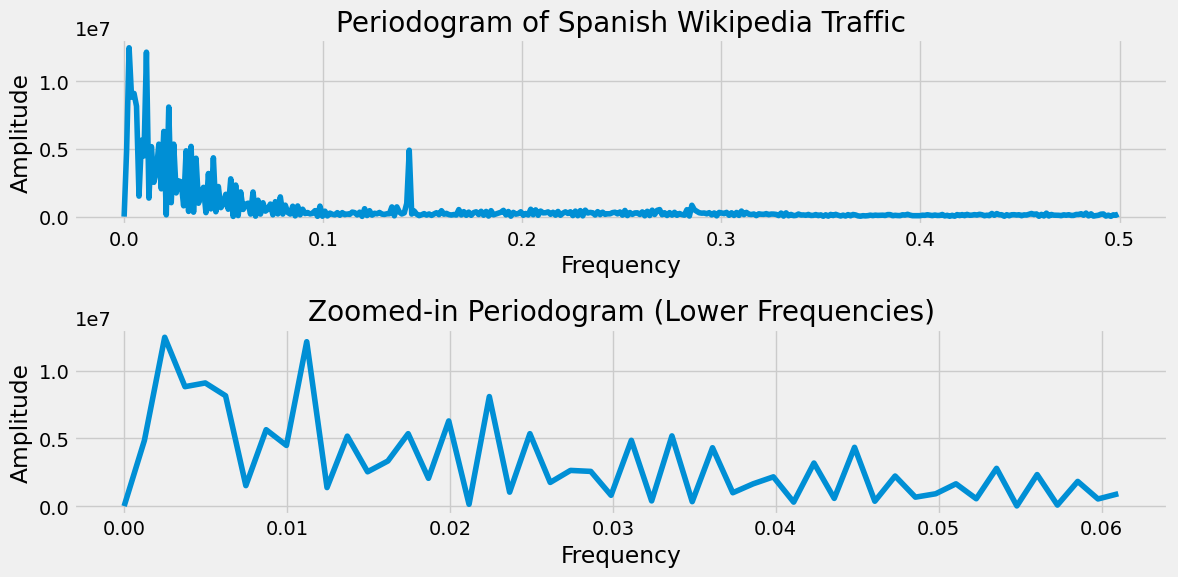

In [37]:
traffic_values = es_wikipedia_traffic.values
time_index = np.arange(len(traffic_values))

# Calculate the periodogram
frequencies, amplitudes = periodogram(traffic_values)

# Use absolute values to handle complex numbers
amplitudes = np.abs(amplitudes)

# Plot the frequency and amplitude
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(frequencies, amplitudes)
plt.title('Periodogram of Spanish Wikipedia Traffic')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
# Zoom in on lower frequencies for a clearer view
plt.plot(frequencies[:50], amplitudes[:50])
plt.title('Zoomed-in Periodogram (Lower Frequencies)')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

The periodogram displays prominent peaks at approximately 20 , 140 and 280(smaller one) days, suggesting a random distribution in the Spanish Wikipedia traffic data. 

### Popular pages in "ru.wikipedia.org"

<Axes: xlabel='Date'>

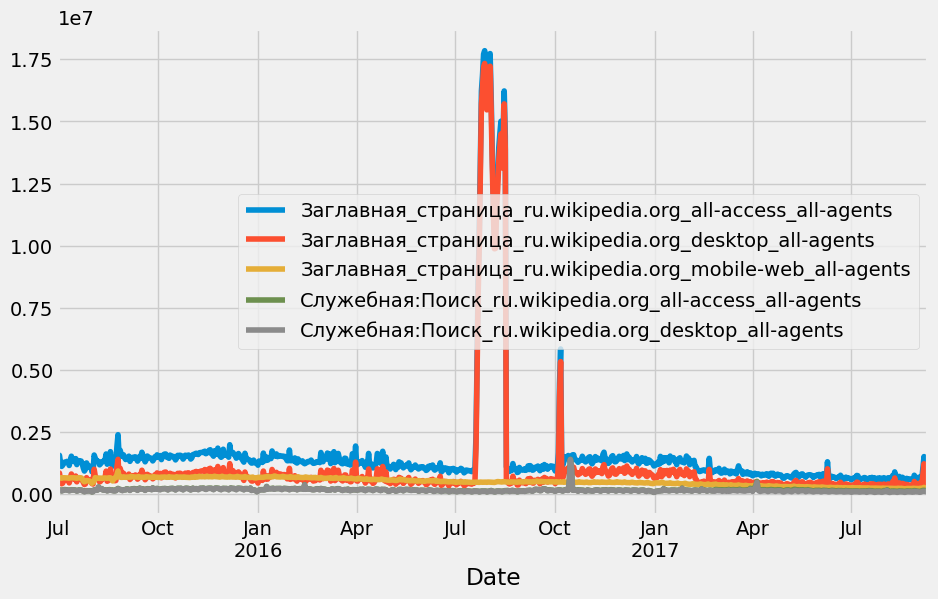

In [38]:
ru_wikipedia_org_columns = data.filter(like="ru.wikipedia.org")

# Calculating the mean values for each page and sorting
top_pages_en = ru_wikipedia_org_columns.mean().sort_values(ascending=False).head(5)

# Plotting the top 5 pages
data[top_pages_en.index].plot(figsize=(10, 6))

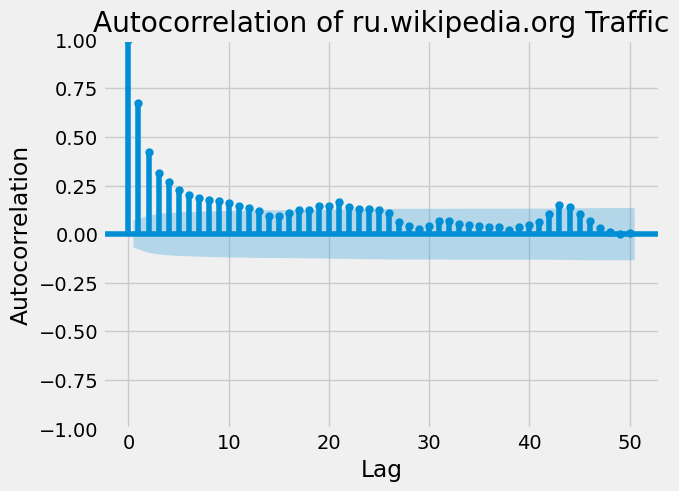

In [39]:
# Find the column that contains "ru.wikipedia.org"
target_column = [col for col in ru_wikipedia_org_columns.columns if "ru.wikipedia.org" in col]

ru_wikipedia_traffic = ru_wikipedia_org_columns[target_column[0]]

# Plot autocorrelation
plot_acf(ru_wikipedia_traffic, lags=50)  # A lag is a day
plt.title("Autocorrelation of ru.wikipedia.org Traffic")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

The autocorrelation plot reveals a significant correlation value at a lag of 5 days( 4 days can be good too )

Conclusion: Rate of accessing the wikipedia pages remains uniform

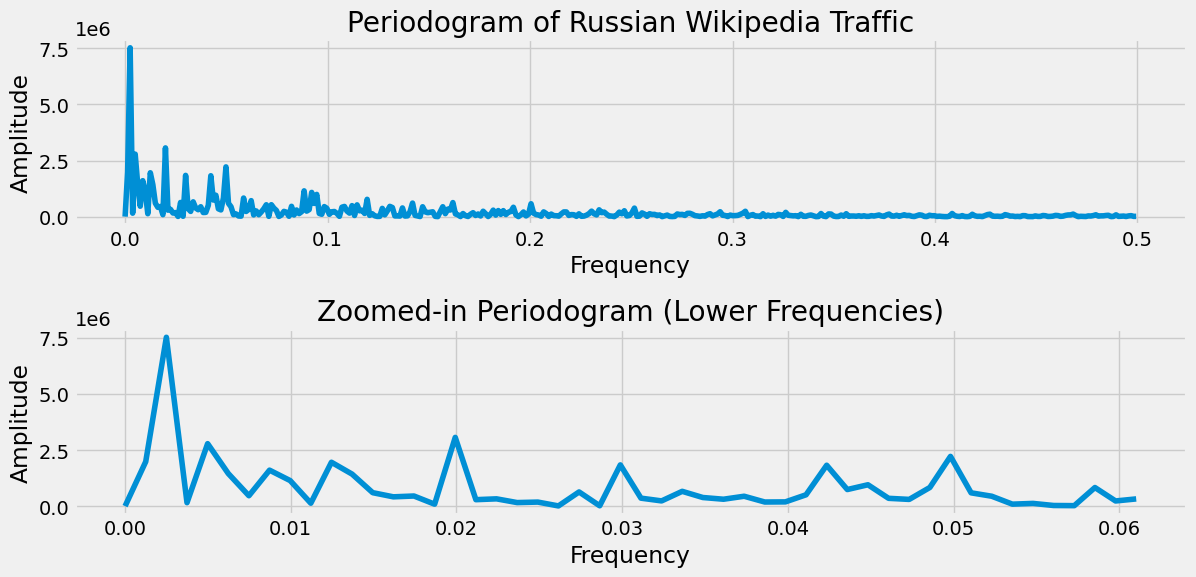

In [40]:
traffic_values = ru_wikipedia_traffic.values
time_index = np.arange(len(traffic_values))

# Calculate the periodogram
frequencies, amplitudes = periodogram(traffic_values)

# Use absolute values to handle complex numbers
amplitudes = np.abs(amplitudes)

# Plot the frequency and amplitude
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(frequencies, amplitudes)
plt.title('Periodogram of Russian Wikipedia Traffic')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
# Zoom in on lower frequencies for a clearer view
plt.plot(frequencies[:50], amplitudes[:50])
plt.title('Zoomed-in Periodogram (Lower Frequencies)')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

The periodogram analysis for Russian Wikipedia traffic data indicates a notable peak at approximately 160 days, suggesting the presence of a periodic pattern with a frequency corresponding to this duration. However, there is no significant peak observed at 230 days.

Conclusion: The absence of a major peak at +200 days indicates that Russian Wikipedia traffic data does not exhibit pronounced seasonality at that specific frequency. While some periodicity is present at 160 days, it is not as prominent as the observed weekly seasonality in the Spanish Wikipedia data.So there is a random distribution.

### Popular pages in "de.wikipedia.org"

<Axes: xlabel='Date'>

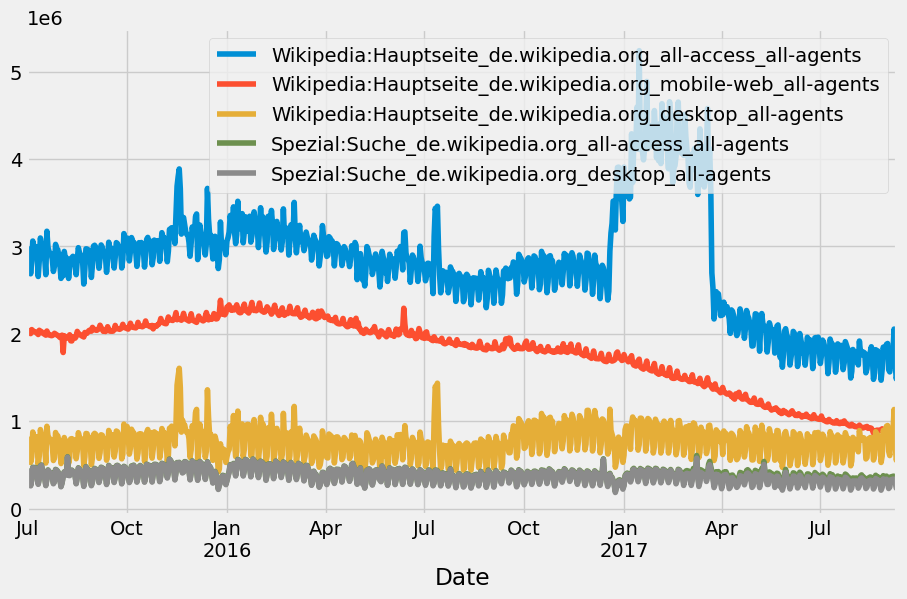

In [41]:
de_wikipedia_org_columns = data.filter(like="de.wikipedia.org")

# Calculating the mean values for each page and sorting
top_pages_en = de_wikipedia_org_columns.mean().sort_values(ascending=False).head(5)

# Plotting the top 5 pages
data[top_pages_en.index].plot(figsize=(10, 6))

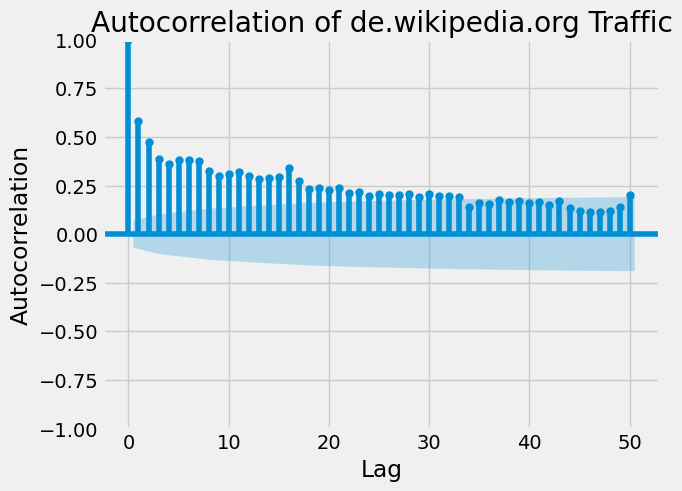

In [42]:
# Find the column that contains "de.wikipedia.org"
target_column = [col for col in de_wikipedia_org_columns.columns if "de.wikipedia.org" in col]

de_wikipedia_traffic = de_wikipedia_org_columns[target_column[0]]

# Plot autocorrelation
plot_acf(de_wikipedia_traffic, lags=50)  # A lag is a day
plt.title("Autocorrelation of de.wikipedia.org Traffic")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

The autocorrelation analysis for the mentioned dataset reveals stronger correlation values at 1 or 2 days lag. Notably, a 8-day lag exhibits higher correlation compared to neighboring lags such as 5, 6, 7, or 9 days.

Conclusion: While the data exhibits some degree of weekly seasonality, it is not as pronounced as observed in other datasets. The higher correlation at a 7-day lag suggests a moderate weekly pattern, but the variations in correlation values at nearby lags indicate a less consistent weekly seasonality compared to other datasets.

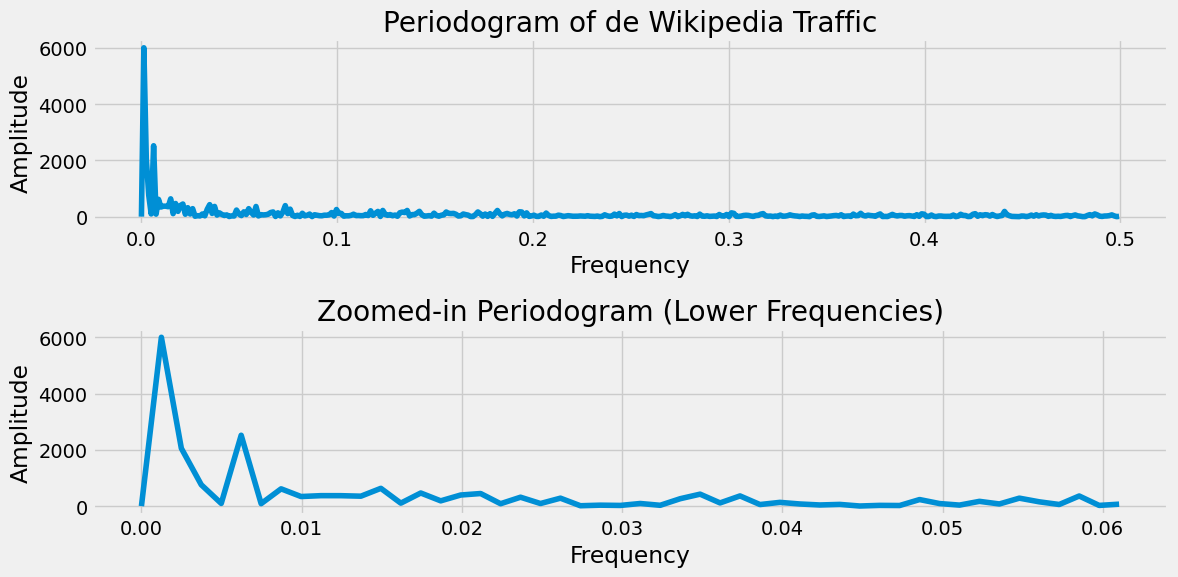

In [43]:
traffic_values = de_wikipedia_traffic.values
time_index = np.arange(len(traffic_values))

# Calculate the periodogram
frequencies, amplitudes = periodogram(traffic_values)

# Use absolute values to handle complex numbers
amplitudes = np.abs(amplitudes)

# Plot the frequency and amplitude
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(frequencies, amplitudes)
plt.title('Periodogram of de Wikipedia Traffic')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
# Zoom in on lower frequencies for a clearer view
plt.plot(frequencies[:50], amplitudes[:50])
plt.title('Zoomed-in Periodogram (Lower Frequencies)')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

Random distribution

### Popular pages in "ja.wikipedia.org"

<Axes: xlabel='Date'>

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 12513 (\N{KATAKANA LETTER ME}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 12506 (\N{KATAKANA LETTER PE}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from current font

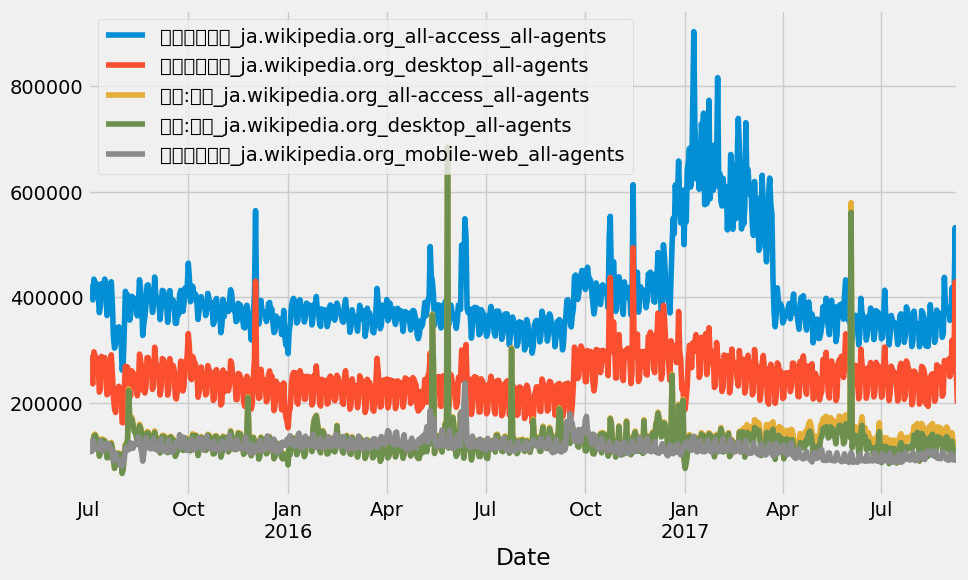

In [44]:
ja_wikipedia_org_columns = data.filter(like="ja.wikipedia.org")

# Calculating the mean values for each page and sorting
top_pages_en = ja_wikipedia_org_columns.mean().sort_values(ascending=False).head(5)

# Plotting the top 5 pages
data[top_pages_en.index].plot(figsize=(10, 6))

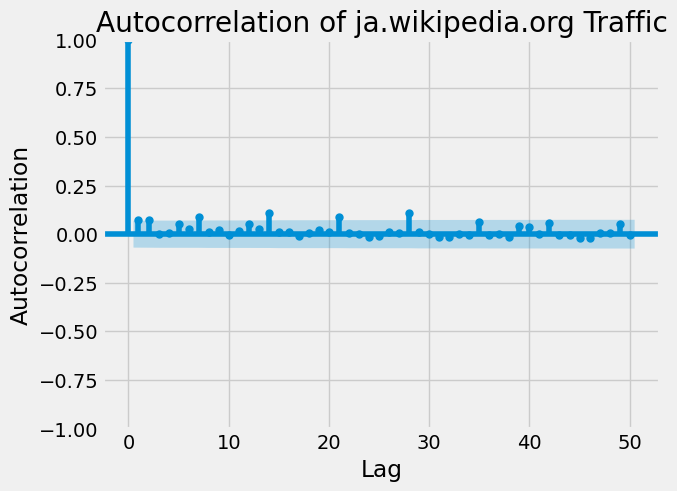

In [45]:
# Find the column that contains "ja.wikipedia.org"
target_column = [col for col in ja_wikipedia_org_columns.columns if "ja.wikipedia.org" in col]

ja_wikipedia_traffic = ja_wikipedia_org_columns[target_column[0]]

# Plot autocorrelation
plot_acf(ja_wikipedia_traffic, lags=50)  # A lag is a day
plt.title("Autocorrelation of ja.wikipedia.org Traffic")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

The autocorrelation analysis for this dataset, similar to other language plots, reveals a strong correlation at a 7-day lag.

Conclusion: The presence of a prominent correlation at a 7-day lag indicates the existence of weekly seasonality in the data.

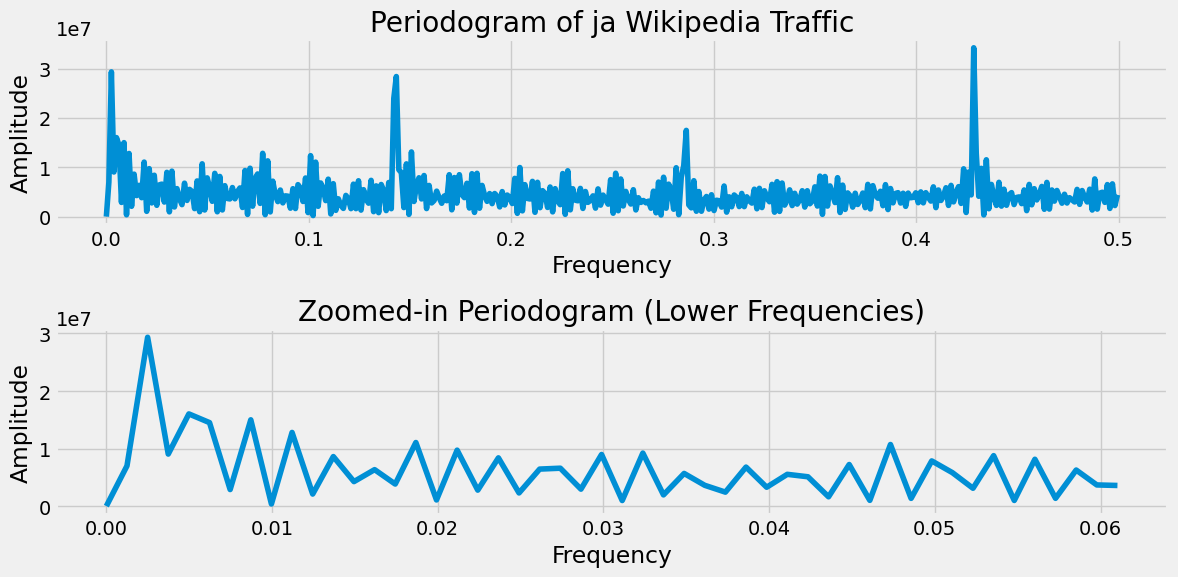

In [46]:
traffic_values = ja_wikipedia_traffic.values
time_index = np.arange(len(traffic_values))

# Calculate the periodogram
frequencies, amplitudes = periodogram(traffic_values)

# Use absolute values to handle complex numbers
amplitudes = np.abs(amplitudes)

# Plot the frequency and amplitude
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(frequencies, amplitudes)
plt.title('Periodogram of ja Wikipedia Traffic')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
# Zoom in on lower frequencies for a clearer view
plt.plot(frequencies[:50], amplitudes[:50])
plt.title('Zoomed-in Periodogram (Lower Frequencies)')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

Significant peaks every 140 days approximately.

### Popular pages in "fr.wikipedia.org"

<Axes: xlabel='Date'>

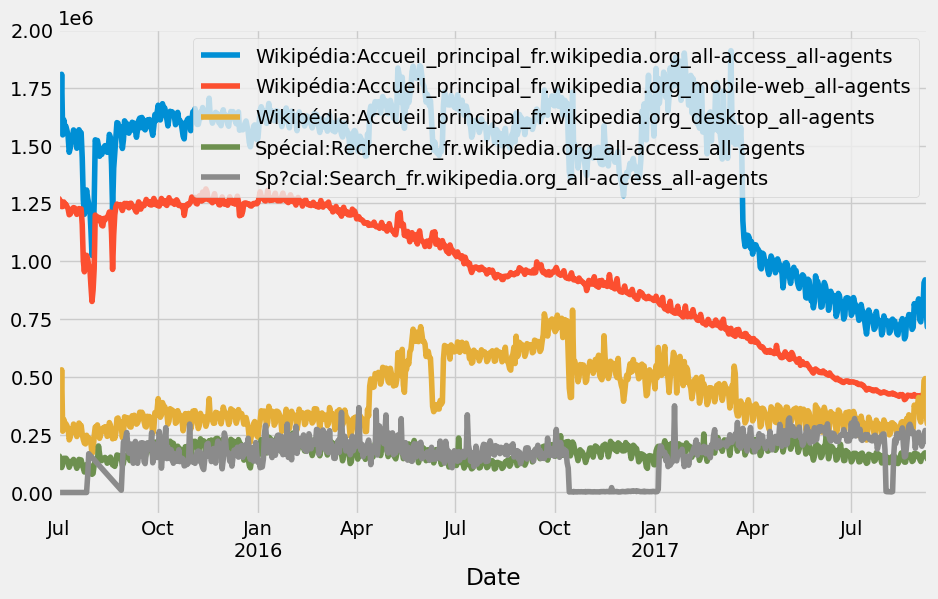

In [47]:
fr_wikipedia_org_columns = data.filter(like="fr.wikipedia.org")

# Calculating the mean values for each page and sorting
top_pages_fr = fr_wikipedia_org_columns.mean().sort_values(ascending=False).head(5)

data[top_pages_fr.index].plot(figsize=(10, 6))

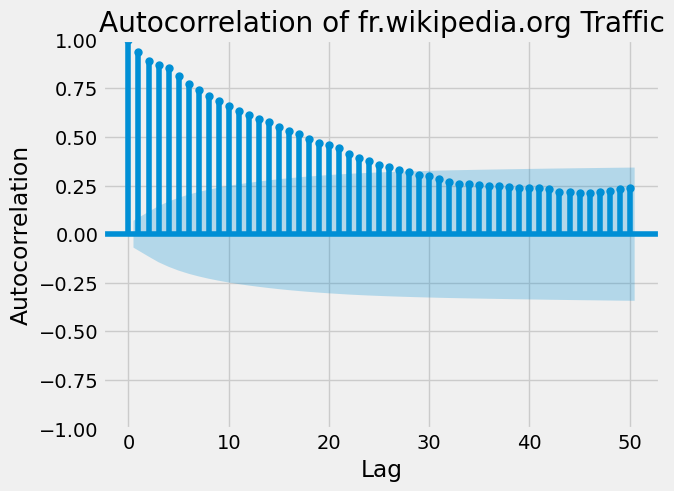

In [48]:
# Find the column that contains "fr.wikipedia.org"
target_column = [col for col in fr_wikipedia_org_columns.columns if "fr.wikipedia.org" in col]

fr_wikipedia_traffic = fr_wikipedia_org_columns[target_column[0]]

# Plot autocorrelation
plot_acf(fr_wikipedia_traffic, lags=50)  # A lag is a day
plt.title("Autocorrelation of fr.wikipedia.org Traffic")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

Weekly seasonality (noticed from the 20 lag to 50 )

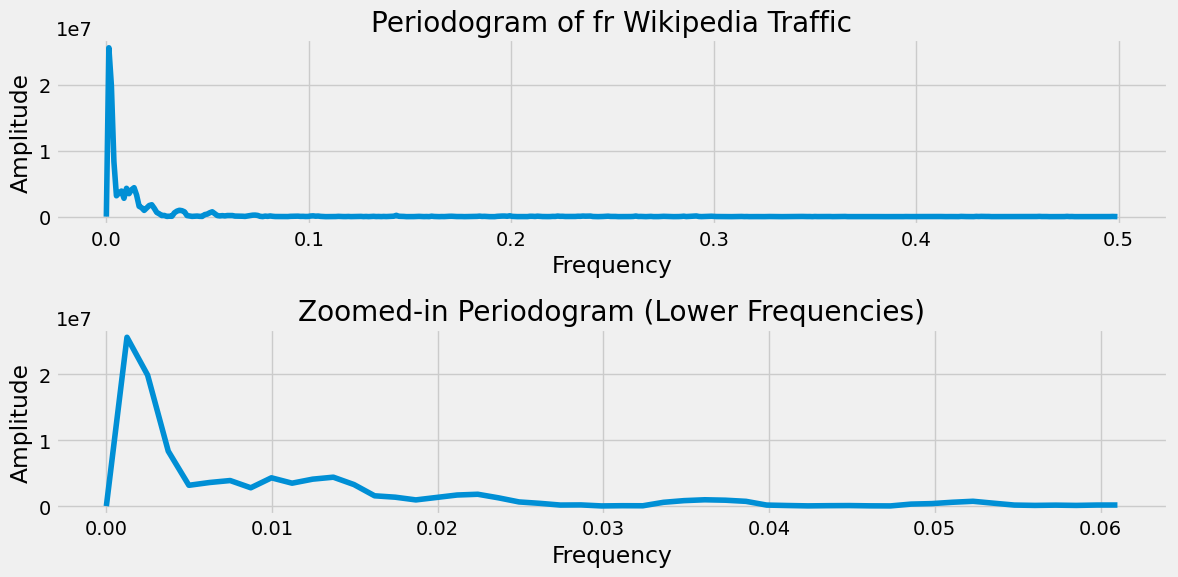

In [49]:
traffic_values = fr_wikipedia_traffic.values
time_index = np.arange(len(traffic_values))

# Calculate the periodogram
frequencies, amplitudes = periodogram(traffic_values)

# Use absolute values to handle complex numbers
amplitudes = np.abs(amplitudes)

# Plot the frequency and amplitude
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(frequencies, amplitudes)
plt.title('Periodogram of fr Wikipedia Traffic')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
# Zoom in on lower frequencies for a clearer view
plt.plot(frequencies[:50], amplitudes[:50])
plt.title('Zoomed-in Periodogram (Lower Frequencies)')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

We can't notice any specific pattern

### Popular pages in "zh.wikipedia.org"

<Axes: xlabel='Date'>

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 39318 (\N{CJK UNIFIED IDEOGRAPH-9996}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 39029 (\N{CJK UNIFIED IDEOGRAPH-9875}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 25628 (\N{CJK UNIFIED IDEOGRAPH-641C}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 32034 (\N{CJK UNIFIED IDEOGRAPH-7D22}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39318 (\N{CJK UNIFIED IDEOGRAPH-9996}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39029 

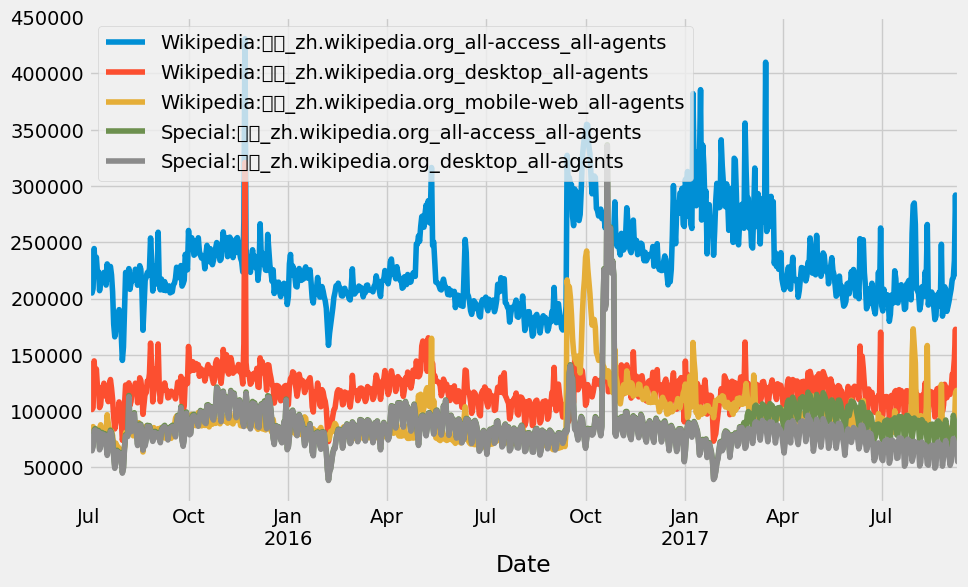

In [50]:
zh_wikipedia_org_columns = data.filter(like="zh.wikipedia.org")

# Calculating the mean values for each page and sorting
top_pages_zh = zh_wikipedia_org_columns.mean().sort_values(ascending=False).head(5)

# Plotting the top 5 pages
data[top_pages_zh.index].plot(figsize=(10, 6))

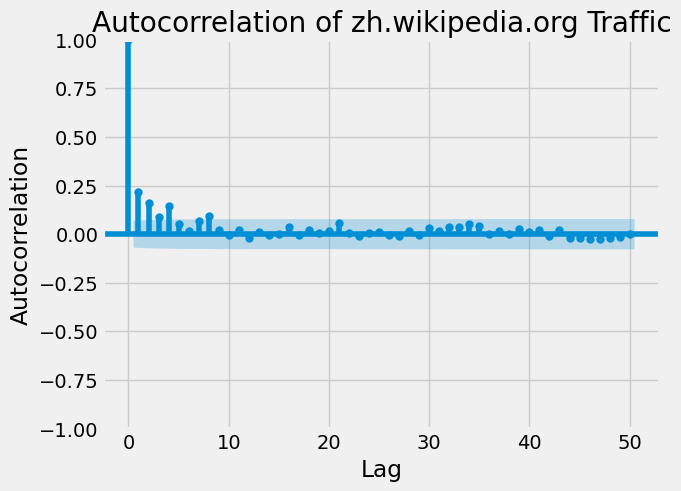

In [51]:
# Find the column that contains "zu.wikipedia.org"
target_column = [col for col in zh_wikipedia_org_columns.columns if "zh.wikipedia.org" in col]

zh_wikipedia_traffic = zh_wikipedia_org_columns[target_column[0]]

# Plot autocorrelation
plot_acf(zh_wikipedia_traffic, lags=50)  # A lag is a day
plt.title("Autocorrelation of zh.wikipedia.org Traffic")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

The autocorrelation analysis reveals stronger correlation values at 1 or 2 days lag.
Conclusion: A less consistent weekly seasonality compared to other datasets.

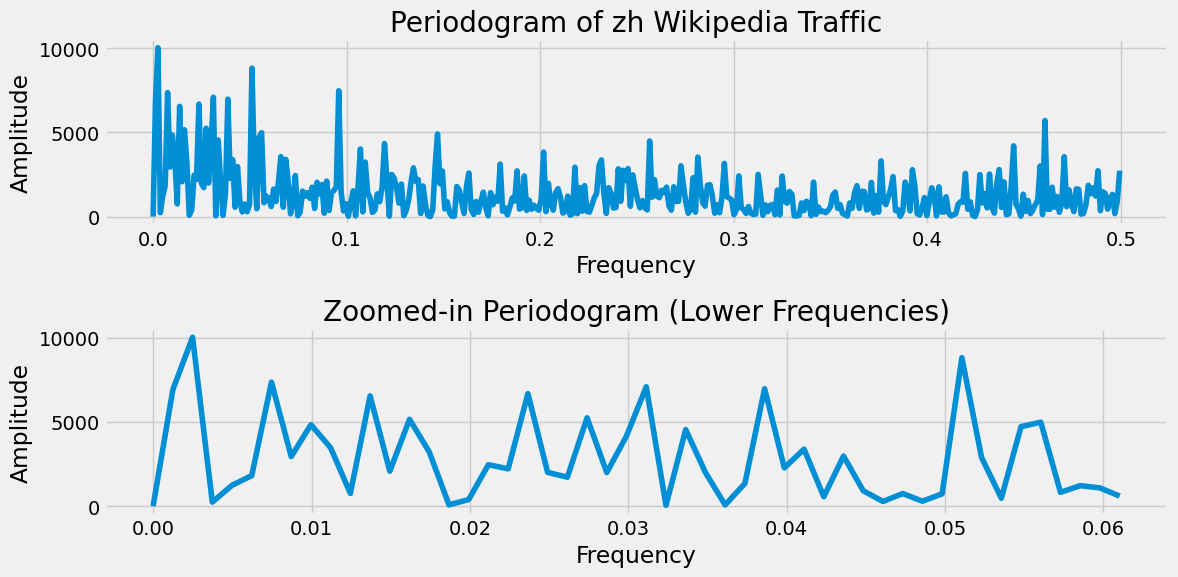

In [52]:
traffic_values = zh_wikipedia_traffic.values
time_index = np.arange(len(traffic_values))

# Calculate the periodogram
frequencies, amplitudes = periodogram(traffic_values)

# Use absolute values to handle complex numbers
amplitudes = np.abs(amplitudes)

# Plot the frequency and amplitude
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(frequencies, amplitudes)
plt.title('Periodogram of zh Wikipedia Traffic')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
# Zoom in on lower frequencies for a clearer view
plt.plot(frequencies[:50], amplitudes[:50])
plt.title('Zoomed-in Periodogram (Lower Frequencies)')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

High correlation for 7 days.
Conclusion- There is weekly seasonality in data.

### Popular pages in "commons.wikipedia.org"

<Axes: xlabel='Date'>

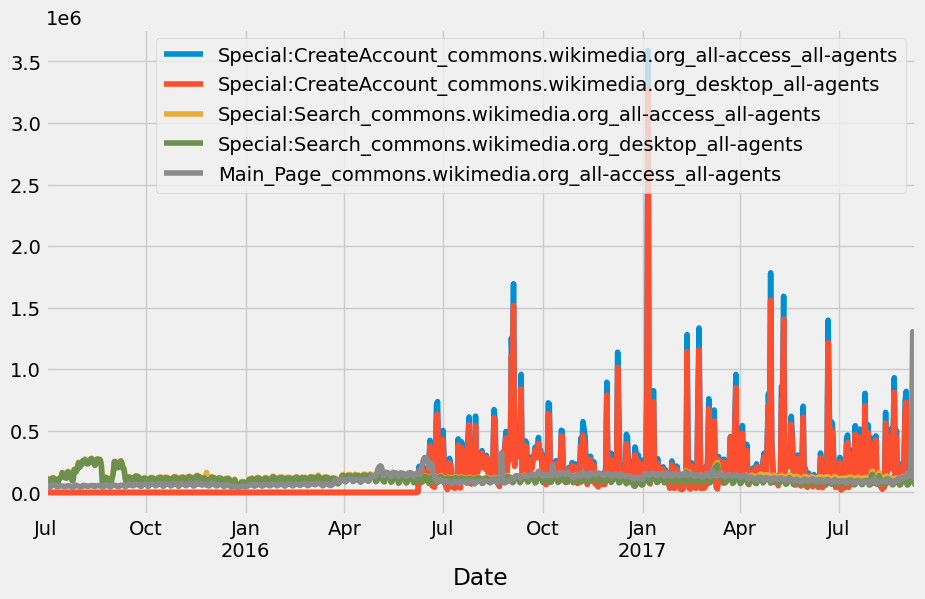

In [53]:
commons_wikipedia_org_columns = data.filter(like="commons.wikimedia.org")

# Calculating the mean values for each page and sorting
top_pages_en = commons_wikipedia_org_columns.mean().sort_values(ascending=False).head(5)

# Plotting the top 5 pages
data[top_pages_en.index].plot(figsize=(10, 6))

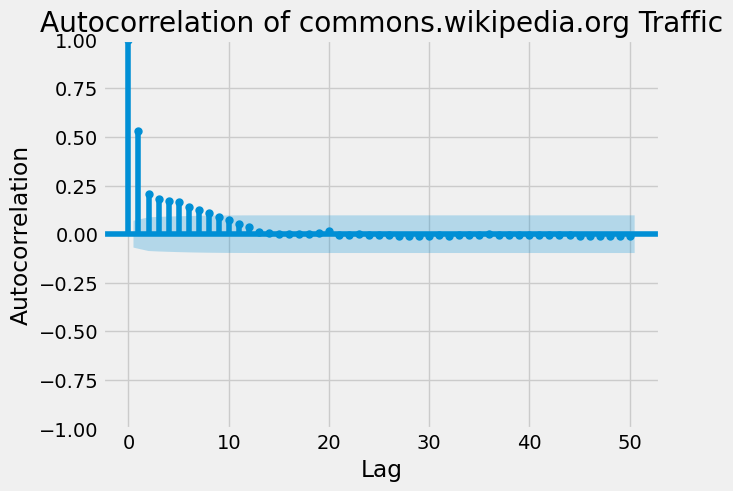

In [54]:
# Find the column that contains "commons.wikipedia.org"
target_column = [col for col in commons_wikipedia_org_columns.columns if "commons.wikimedia.org" in col]
commons_wikipedia_traffic = commons_wikipedia_org_columns[target_column[0]]

# Plot autocorrelation
plot_acf(commons_wikipedia_traffic, lags=50)  # A lag is a day
plt.title("Autocorrelation of commons.wikipedia.org Traffic")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

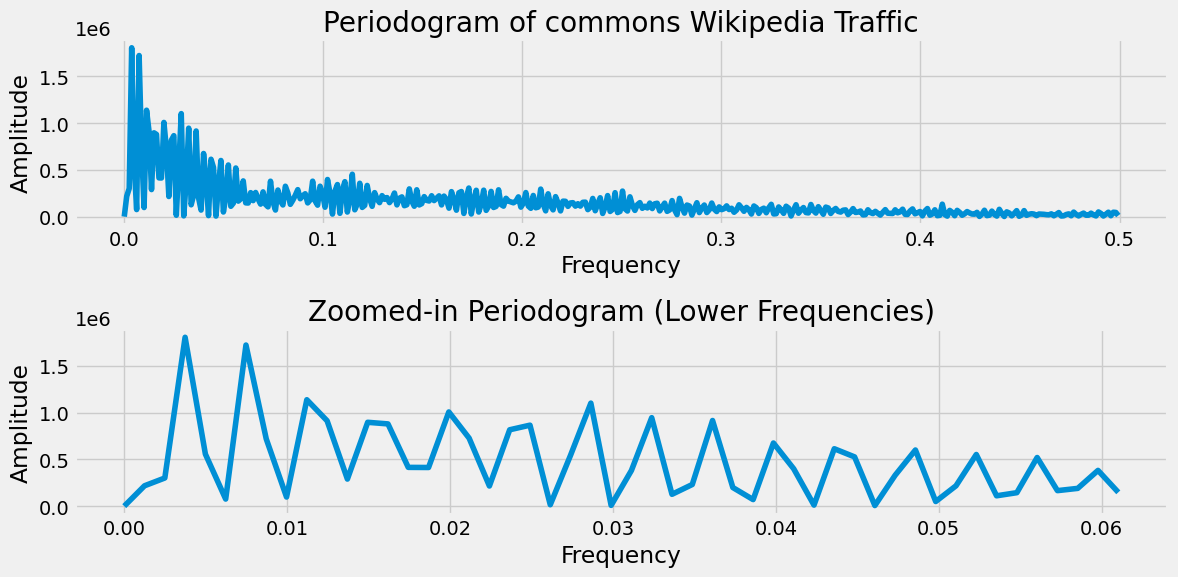

In [55]:
traffic_values = commons_wikipedia_traffic.values
time_index = np.arange(len(traffic_values))

# Calculate the periodogram
frequencies, amplitudes = periodogram(traffic_values)

# Use absolute values to handle complex numbers
amplitudes = np.abs(amplitudes)

# Plot the frequency and amplitude
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(frequencies, amplitudes)
plt.title('Periodogram of commons Wikipedia Traffic')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
# Zoom in on lower frequencies for a clearer view
plt.plot(frequencies[:50], amplitudes[:50])
plt.title('Zoomed-in Periodogram (Lower Frequencies)')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

There is a weekly seasonality

### Popular pages in "wwW.mediawiki.org"

<Axes: xlabel='Date'>

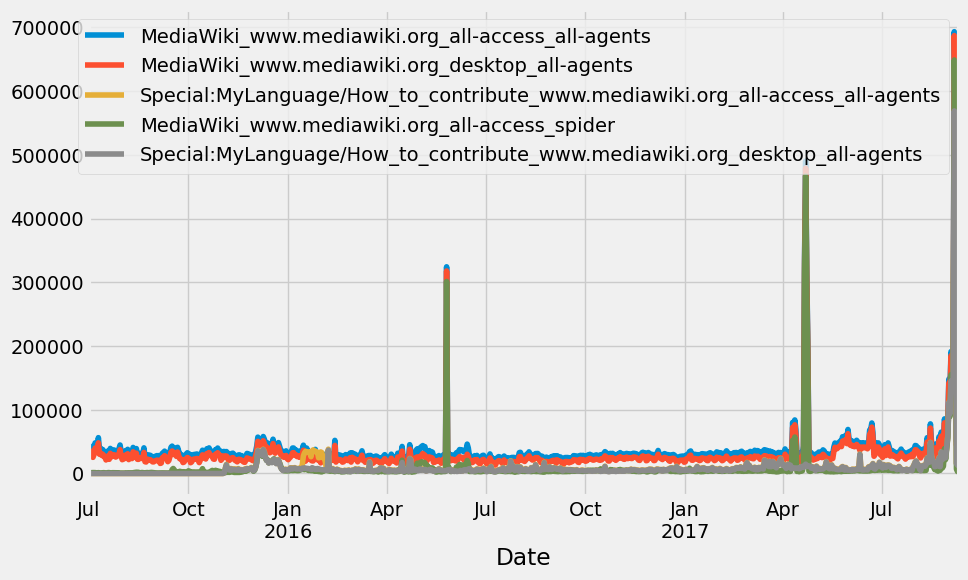

In [56]:
media_wikipedia_org_columns = data.filter(like="www.mediawiki.org")

# Calculating the mean values for each page and sorting
top_pages_en = media_wikipedia_org_columns.mean().sort_values(ascending=False).head(5)

# Plotting the top 5 pages
data[top_pages_en.index].plot(figsize=(10, 6))

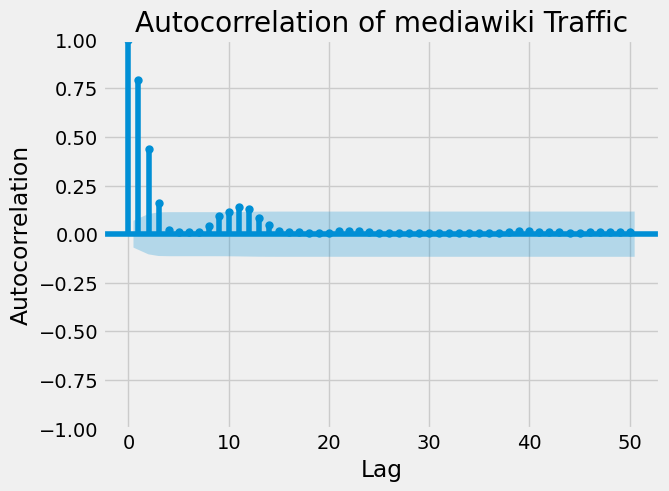

In [57]:
# Find the column that contains "media.wikipedia.org"
target_column = [col for col in media_wikipedia_org_columns.columns if "www.mediawiki.org" in col]
media_wikipedia_traffic = media_wikipedia_org_columns[target_column[0]]

# Plot autocorrelation
plot_acf(media_wikipedia_traffic, lags=50)  # A lag is a day
plt.title("Autocorrelation of mediawiki Traffic")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

There is no weekly seasonality in the data

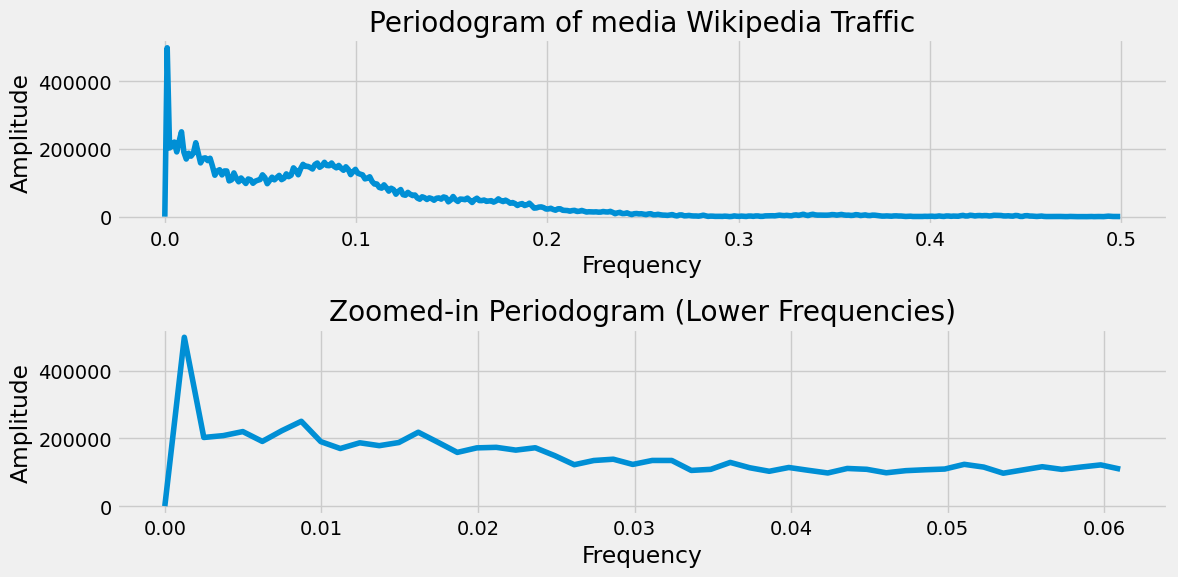

In [58]:
traffic_values = media_wikipedia_traffic.values
time_index = np.arange(len(traffic_values))

# Calculate the periodogram
frequencies, amplitudes = periodogram(traffic_values)

# Use absolute values to handle complex numbers
amplitudes = np.abs(amplitudes)

# Plot the frequency and amplitude
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(frequencies, amplitudes)
plt.title('Periodogram of media Wikipedia Traffic')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
# Zoom in on lower frequencies for a clearer view
plt.plot(frequencies[:50], amplitudes[:50])
plt.title('Zoomed-in Periodogram (Lower Frequencies)')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

There is no weekly seasonality

**Conclusions**

As anticipated, English Wikipedia exhibits the highest traffic among all languages, with a notable pattern around August 2016. Interestingly, Russian Wikipedia follows a similar pattern during the same timeframe. Additionally, an observable pattern around January 2016 in English Wikipedia coincides with spikes in Japanese Wikipedia during that period.

In summary, there are distinct variations in traffic based on the language of the data. Upon analyzing traffic across all languages, a common trend emerges: an upward trajectory during the initial months and a corresponding downward trend in the final months. However, it is crucial to note that this does not imply uniformity across all time series.Disctinct project plays a significant role in influencing page traffic. This insight suggests that incorporating language as a feature can be beneficial during the modeling phase.

Concerning the periodogram analysis, it provided valuable insights. Most projects displayed peaks at 140 and 280 days, with some also exhibiting peaks at 340 days. Information about these three prominent peaks can later prove beneficial during the modeling phase.

## Analysis based on different access types and different agents

In [59]:
access_types = [col.split("_")[-2] for col in data.columns]
agents = [col.split("_")[-1] for col in data.columns]

In [60]:
access_types = [col.split("_")[-2] for col in data.columns]
access_dict = Counter(access_types)

In [61]:
access_dict

Counter({'all-access': 74315, 'mobile-web': 35939, 'desktop': 34809})

In [62]:
print("Number of topics with all-access type:", access_dict["all-access"])
print("Number of topics with desktop access:", access_dict["desktop"])
print("Number of topics with mobile-web access:", access_dict["mobile-web"])

Number of topics with all-access type: 74315
Number of topics with desktop access: 34809
Number of topics with mobile-web access: 35939


In [63]:
access_types = [col.split("_")[-2] for col in data.columns]
access_dict = Counter(access_types)

access_data = pd.DataFrame(list(access_dict.items()), columns=["Access type", "Number of columns"])
access_data

Access type  Number of columns
0  all-access              74315
1     desktop              34809
2  mobile-web              35939

In [64]:
agents_dict = Counter(col.split("_")[-1] for col in data.columns)
agents_dict

Counter({'all-agents': 110150, 'spider': 34913})

In [65]:
print("Number of topics with all-agents as agent:", agents_dict["all-agents"])
print("Number of topics with spider as agent:", agents_dict["spider"])

Number of topics with all-agents as agent: 110150
Number of topics with spider as agent: 34913


In [66]:
agents_dict = Counter(col.split("_")[-1] for col in data.columns)
agents_data = pd.DataFrame(list(agents_dict.items()), columns=["Agent", "Number of columns"])
agents_data

Agent  Number of columns
0      spider              34913
1  all-agents             110150

In [67]:
access_data_list = [np.zeros(data.shape[0]) for _ in range(3)]
access_number = [0, 0, 0]

for i in tnrange(len(Page)):
    add_list = data.iloc[:, i].values
    k = max([i.start() for i in re.finditer('org_', Page[i])])

    if 'all-access' in Page[i][k:]:
        access_data_list[0] = np.add(access_data_list[0], add_list)
        access_number[0] += 1

    if 'desktop' in Page[i][k:]:
        access_data_list[1] = np.add(access_data_list[1], add_list)
        access_number[1] += 1

    if 'mobile' in Page[i][k:]:
        access_data_list[2] = np.add(access_data_list[2], add_list)
        access_number[2] += 1

/tmp/ipykernel_42/772965721.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(Page)):


  0%|          | 0/145063 [00:00<?, ?it/s]

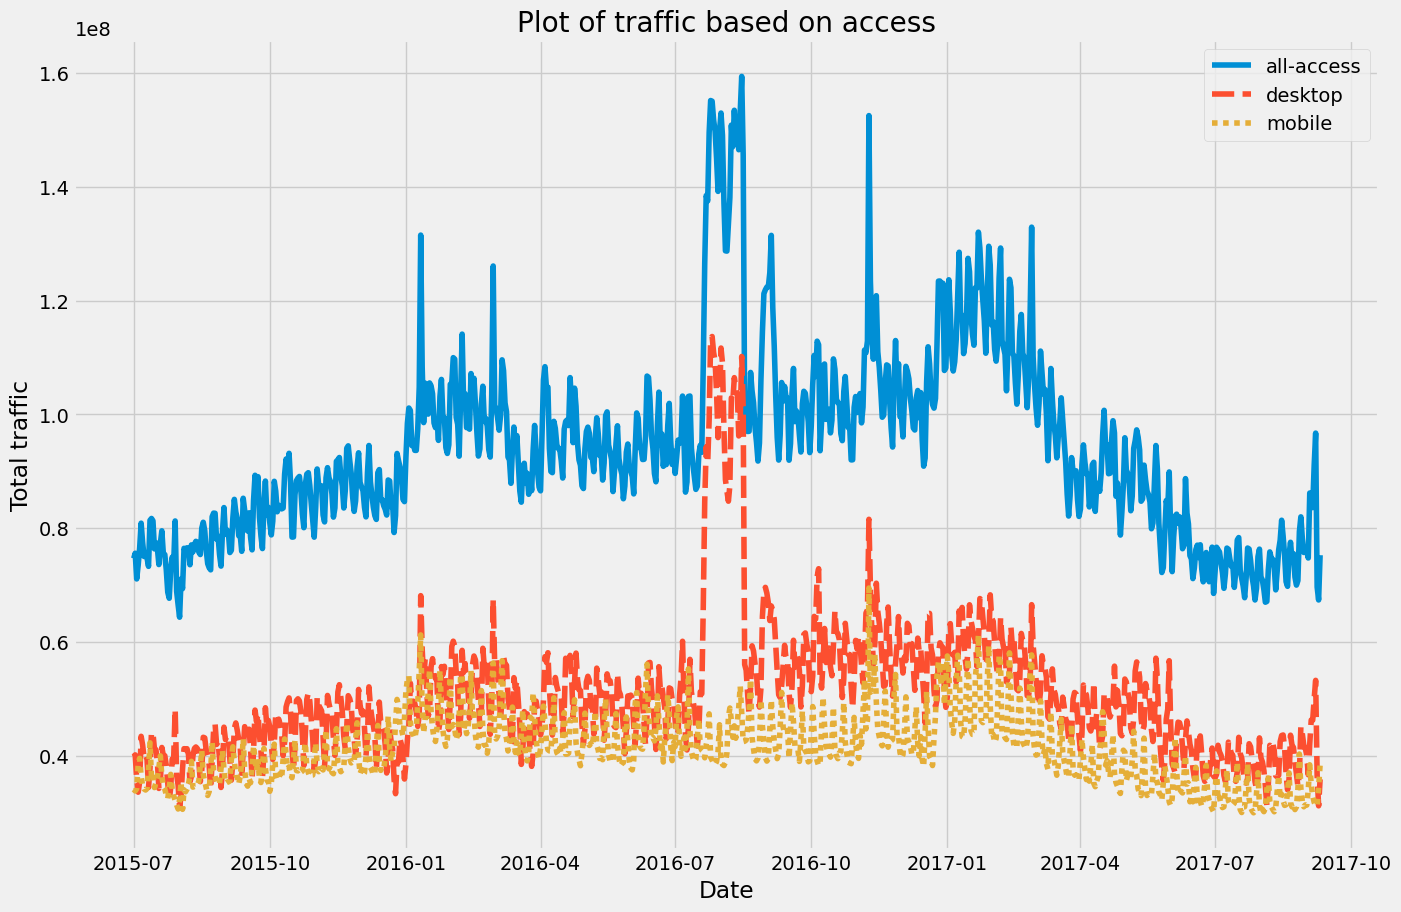

In [68]:
access_data = pd.DataFrame(access_data_list, index=['all-access', 'desktop', 'mobile'], columns=data.transpose().columns.values[0:])

plt.figure(figsize=(15, 10))
sns.lineplot(data=access_data.transpose())
plt.title('Plot of traffic based on access')
plt.xlabel('Date')
plt.ylabel('Total traffic')
plt.show()

Upon further examination, we observe that the traffic patterns for all-access and desktop align with our expectations. However, the mobile data reveals a distinct trend. In contrast to all-access and desktop, which exhibit a peak around August 2016, the mobile data not only fails to show a spike but also demonstrates a decline during that period. This unexpected pattern is contrary to our initial assumptions.

Now, revisiting the language-specific plots, it becomes apparent that Spanish and German Wikipedia share a similar trend around August 2016, both experiencing a decrease in traffic. Conclusion: This suggests that the majority of mobile traffic during August 2016 is attributed to Spanish and German Wikipedia, while English Wikipedia sees comparatively less access via mobile devices.

## Analysis based on 3 splits

In [69]:
total_days = data.shape[0] - 1
data1_days = 184
data2_days = 360
data3_days = total_days - data1_days - data2_days

# Initialize lists for medians
data1_med = []
data2_med = []
data3_med = []

# Loop through the data
for i in tnrange(len(Page)):
    # Calculate medians for each part using array slicing
    data1_med.append(np.median(data.transpose().iloc[i].values[1:data1_days + 1]))
    data2_med.append(np.median(data.transpose().iloc[i].values[data1_days + 1: data1_days + data2_days + 1]))
    data3_med.append(np.median(data.transpose().iloc[i].values[data1_days + data2_days + 1:]))

# Now data1_med, data2_med, and data3_med contain medians for each part of the time series data.

/tmp/ipykernel_42/36446991.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(Page)):


  0%|          | 0/145063 [00:00<?, ?it/s]

In [72]:
med_data=pd.DataFrame([data1_med,data2_med,data3_med],index=['data1','data2','data3'])
med_data

0       1       2       3       4       5       6       7       8       \
data1    11.0    15.0     3.0    10.0     0.0     9.0     0.0    25.0    23.0   
data2    18.0    18.0     4.0    14.0     3.0    15.0     0.5    39.0    33.5   
data3    22.0    21.0     3.0    16.0    16.0    17.0     7.0    34.5    41.0   

       9       ...  145053  145054  145055  145056     145057  145058  145059  \
data1    14.0  ...     0.0     0.0     0.0     0.0   0.000000     0.0     0.0   
data2    25.0  ...     0.0     0.0     0.0     0.0   0.000000     0.0     0.0   
data3    26.0  ...     6.0     8.5     4.0    17.0  25.785714     6.0     8.0   

       145060  145061  145062  
data1     0.0     0.0     0.0  
data2     0.0     0.0     0.0  
data3    21.5     7.0     8.0  

[3 rows x 145063 columns]

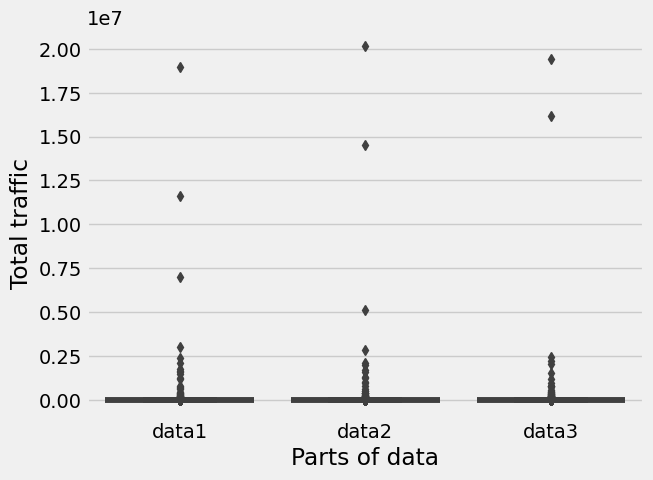

In [73]:
sns.boxplot(data=med_data.transpose())
plt.xlabel('Parts of data')
plt.ylabel('Total traffic')
plt.show()

The box plots reveal that the majority of the data is concentrated below the 5000 traffic level. However, it is evident from the presence of outliers that certain time series exhibit a median significantly higher than the median of the majority of time series. This suggests the existence of specific instances or patterns within the data where the traffic is substantially higher than the norm. Further investigation into these outliers may provide valuable insights into the underlying factors influencing traffic patterns.

In [74]:
# This will give us a in-depth look of the medians of the time series
x=[25,50,75,100]
print('For part 1 : ')
for i in x:
    print('{}th percentile of part1 is : '.format(i),np.percentile(data1_med,i))
print('For part 2 : ')
for i in x:
    print('{}th percentile of part2 is : '.format(i),np.percentile(data2_med,i))
print('For part 3 : ')
for i in x:
    print('{}th percentile of part3 is : '.format(i),np.percentile(data3_med,i))

For part 1 : 
25th percentile of part1 is :  6.0
50th percentile of part1 is :  70.0
75th percentile of part1 is :  460.0
100th percentile of part1 is :  18952124.5
For part 2 : 
25th percentile of part2 is :  13.0
50th percentile of part2 is :  116.0
75th percentile of part2 is :  544.0
100th percentile of part2 is :  20129672.5
For part 3 : 
25th percentile of part3 is :  18.0
50th percentile of part3 is :  123.0
75th percentile of part3 is :  529.0
100th percentile of part3 is :  19423716.0


A notable observation is the considerable gap between the 75th and 100th percentiles across all segments , lets look more closely in this range.

In [75]:
x=[80,85,90,95,100]
print('For part 1 : ')
for i in x:
    print('{}th percentile of part1 is : '.format(i),np.percentile(data1_med,i))
print('For part 2 : ')
for i in x:
    print('{}th percentile of part2 is : '.format(i),np.percentile(data2_med,i))
print('For part 3 : ')
for i in x:
    print('{}th percentile of part3 is : '.format(i),np.percentile(data3_med,i))

For part 1 : 
80th percentile of part1 is :  634.0
85th percentile of part1 is :  883.0
90th percentile of part1 is :  1300.5
95th percentile of part1 is :  2304.949999999997
100th percentile of part1 is :  18952124.5
For part 2 : 
80th percentile of part2 is :  724.5
85th percentile of part2 is :  986.0
90th percentile of part2 is :  1433.4000000000015
95th percentile of part2 is :  2529.5
100th percentile of part2 is :  20129672.5
For part 3 : 
80th percentile of part3 is :  698.0
85th percentile of part3 is :  943.5
90th percentile of part3 is :  1390.0
95th percentile of part3 is :  2464.449999999997
100th percentile of part3 is :  19423716.0


As we approach the 100th percentile values, there is a noticeable upward trend in the medians of the time series data. However, it's particularly noteworthy that the 100th percentile values appear disproportionately large, indicating the presence of extreme outliers.

In [76]:
x=[96,97,98,99,100]
print('For part 1 : ')
for i in x:
    print('{}th percentile of part1 is : '.format(i),np.percentile(data1_med,i))
print('For part 2 : ')
for i in x:
    print('{}th percentile of part2 is : '.format(i),np.percentile(data2_med,i))
print('For part 3 : ')
for i in x:
    print('{}th percentile of part3 is : '.format(i),np.percentile(data3_med,i))

For part 1 : 
96th percentile of part1 is :  2753.5
97th percentile of part1 is :  3437.5699999999924
98th percentile of part1 is :  4574.020000000019
99th percentile of part1 is :  6791.690000000002
100th percentile of part1 is :  18952124.5
For part 2 : 
96th percentile of part2 is :  2983.5199999999895
97th percentile of part2 is :  3663.5699999999924
98th percentile of part2 is :  4729.640000000014
99th percentile of part2 is :  6922.190000000002
100th percentile of part2 is :  20129672.5
For part 3 : 
96th percentile of part3 is :  2931.7599999999948
97th percentile of part3 is :  3637.0
98th percentile of part3 is :  4840.880000000005
99th percentile of part3 is :  7182.020000000019
100th percentile of part3 is :  19423716.0


The presence of outliers is notably evident between the 99th and 100th percentiles, contributing to the disproportionately large values in the uppermost range of the dataset.

In [77]:
x=[99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
for i in x:
    print('{}th percentile of part1 is : '.format(i),np.percentile(data1_med,i))
print('For part 2 : ')
for i in x:
    print('{}th percentile of part2 is : '.format(i),np.percentile(data2_med,i))
print('For part 3 : ')
for i in x:
    print('{}th percentile of part3 is : '.format(i),np.percentile(data3_med,i))

99.1th percentile of part1 is :  7131.26800000004
99.2th percentile of part1 is :  7594.791999999856
99.3th percentile of part1 is :  8187.77299999987
99.4th percentile of part1 is :  8870.268000000156
99.5th percentile of part1 is :  9734.725000000006
99.6th percentile of part1 is :  10848.460000000327
99.7th percentile of part1 is :  11980.675000000163
99.8th percentile of part1 is :  14442.76399999985
99.9th percentile of part1 is :  21252.00100000153
100th percentile of part1 is :  18952124.5
For part 2 : 
99.1th percentile of part2 is :  7323.94200000001
99.2th percentile of part2 is :  7832.027999999904
99.3th percentile of part2 is :  8351.763999999966
99.4th percentile of part2 is :  9011.94200000004
99.5th percentile of part2 is :  9804.845000000001
99.6th percentile of part2 is :  10855.168000000165
99.7th percentile of part2 is :  12659.826000000117
99.8th percentile of part2 is :  15398.519999999786
99.9th percentile of part2 is :  22924.376000000047
100th percentile of par

To enhance median analysis, we are presently excluding outliers beyond the 99.9th percentile from the three median lists. However, the comprehensive removal of outliers from the main dataset will be addressed in the upcoming Data Preprocessing phase of the case study.

In [78]:
#Substituting values exceeding the 99.9th percentile with the median of their respective lists to facilitate a more focused and reliable analysis.

x=[data1_med,data2_med,data3_med]
for j in x:
    percentil=np.percentile(j,99.9)
    for i in tnrange(len(j)):
        if(j[i]>percentil):
            j[i]=np.median(j)

/tmp/ipykernel_42/599034460.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(j)):


  0%|          | 0/145063 [00:00<?, ?it/s]

  0%|          | 0/145063 [00:00<?, ?it/s]

  0%|          | 0/145063 [00:00<?, ?it/s]

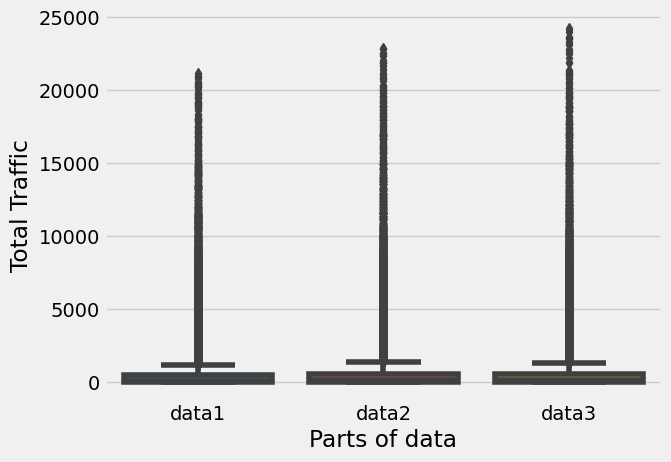

In [79]:
# Box plots after outlier replacement
med1_data = pd.DataFrame([data1_med, data2_med, data3_med], index=['data1', 'data2', 'data3'])
sns.boxplot(data=med1_data.transpose())
plt.xlabel('Parts of data')
plt.ylabel('Total Traffic')
plt.show()

The noticeable elongation of whiskers in the box plots indicates a substantial spread in the data. In conclusion, the plots highlight that the majority (75%) of the total values are comparatively small when contrasted with the last 25% of values, and this pattern is consistent across all segments of the data.

/tmp/ipykernel_42/360890303.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data1_med)


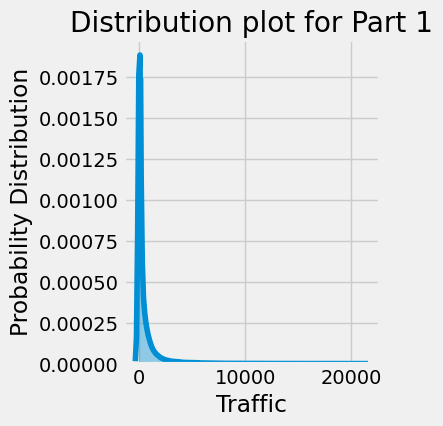

/tmp/ipykernel_42/360890303.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data2_med)


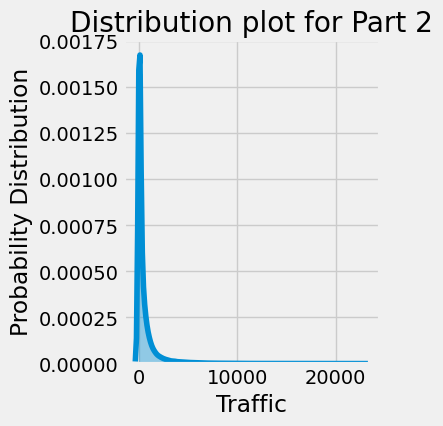

/tmp/ipykernel_42/360890303.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data3_med)


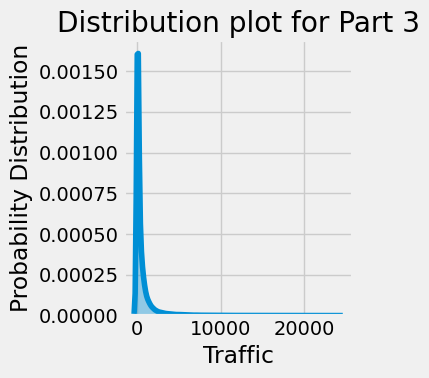

In [80]:
# Distribution plots for the medians of each time series based on data segments
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
sns.distplot(data1_med)
plt.title('Distribution plot for Part 1')
plt.xlabel('Traffic')
plt.ylabel('Probability Distribution')
plt.show()
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 2)
sns.distplot(data2_med)
plt.title('Distribution plot for Part 2')
plt.xlabel('Traffic')
plt.ylabel('Probability Distribution')
plt.show()
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 3)
sns.distplot(data3_med)
plt.title('Distribution plot for Part 3')
plt.xlabel('Traffic')
plt.ylabel('Probability Distribution')

plt.tight_layout()
plt.show()


The evident skewness in the distribution plots indicates a highly skewed nature of the data, with a predominant concentration of small traffic values. In conclusion, among the 145k time series in our dataset, a substantial majority exhibits lower traffic levels, emphasizing the prevalence of smaller values across the dataset.

# Data Preprocessing

During the exploratory data analysis phase, it became apparent that peaks in the data tend to exhibit a regular occurrence pattern, while a small number of exceptionally large peaks are infrequent, happening only once or twice. Recognizing the potential disruption these infrequent peaks may introduce to predictive modeling, we have opted to replace them with the median of the dataset. This step aims to improve the robustness of predictions by mitigating the impact of outlier-like values that could adversely affect the learning process.

In [81]:
col = data.transpose().columns
for index, row in data.transpose().iterrows():
    values = row.values[1:]
    threshold = np.percentile(values, 99.9)
    median_value = np.median(values)

    data.transpose().loc[index, col[1:]] = np.where(row[col[1:]] > threshold, median_value, row[col[1:]])

In [1]:
data.transpose().head()

NameError: name 'data' is not defined

# Feature engineering

In [ ]:
fdata=data.transpose()

In [ ]:
week_day=[]
# This list will contain 145063*20 values, each corresponding to the week day of every data point that we are creating
temp_week=[]
#There is a high correlation for 7 days , so will try to capture the traffic on d-7 days:
weekly_trend=[]

fourdays_1=[] # It will contain the total traffic for d-4 to d days
fourdays_2=[] # It will contain the total traffic for d-8 to d-4 days
fourdays_3=[] # It will contain the total traffic for d-12 to d-8 days

target=[]
l=len(fdata.columns)
for i in (fdata.columns[l-20:l]):
    d=str(i).split('-')
    date=datetime.date(int(d[0]),int(d[1]),int(d[2].split(' ')[0]))
    temp_week.append(date.weekday())



for j in tqdm(range(fdata.shape[0])):
    k=fdata.iloc[j].values


    weekly_temp=[]
    for i in range(784,804):
        weekly_temp.append(k[i-7])
    weekly_trend.extend(weekly_temp)
    temp_list=[]
    temp_list1=[]
    temp_list2=[]
    for i in range(784,804):
        temp_list.append(k[i-1]+k[i-2]+k[i-3]+k[i-4])
        temp_list1.append(k[i-5]+k[i-6]+k[i-7]+k[i-8])
        temp_list2.append(k[i-9]+k[i-10]+k[i-11]+k[i-12])
        target.append(k[i])
    fourdays_1.extend(temp_list)
    fourdays_2.extend(temp_list1)
    fourdays_3.extend(temp_list2)
    week_day.extend(temp_week)



In [ ]:
# As we know that projects do we have an impact on traffic, so I will use projects based on their languages

project_list = ['de', 'en', 'es', 'fr', 'ja', 'nt', 'ru', 'zh'] # nt refers for MediaWiki
prj=[]
for k in tqdm(Page):
    index=k.find('.wikipedia')
    temp_prj=[]

  # As we creating features for last 20 days so every page will have 20 rows in data , we will append the project of a page 20 times to the list
    for i in range(20):
        temp_prj.append(project_list.index(k[index-1:index-3:-1][::-1]))
    prj.extend(temp_prj)

In [ ]:
spider=[]  # 1 for spider data and 0 for non spider data
for i in tnrange(len(Page)):
    temp_spider=[]
    if('spider' in Page[i]):
        for k in range(20):
            temp_spider.append(1)
    else:
        for k in range(20):
            temp_spider.append(0)
    spider.extend(temp_spider)

In [ ]:
access=[] # 0 for all access, 1 for mobile and 2 for desktop
for i in tnrange(len(Page)):
    temp_access=[]
    k=max([i.start() for i in re.finditer('org_',Page[i])])
    if('all-access' in Page[i][k:]):
        for j in range(20):
            temp_access.append(0)
    if('mobile' in Page[i][k:]):
        for j in range(20):
            temp_access.append(1)
    if('desktop' in Page[i][k:]):
        for j in range(20):
            temp_access.append(2)

    access.extend(temp_access)

In [ ]:
fourier1_x = []
fourier2_x = []
fourier3_x = []
fourier1_y = []
fourier2_y = []
fourier3_y = []

for t in tnrange(len(Page)):
    fftdata = fdata.iloc[t].values
    fftdata = fftdata - np.mean(fftdata)
    x = np.fft.fft(fftdata)
    freq = np.linspace(0, 804 // 2, 804 // 2)
    y = 2 / 804 * np.abs(x[:804 // 2])

    # Top 3 peaks indices
    top_indices = np.argsort(y[20:])[-3:] + 20

    for i, index in enumerate(top_indices):
        temp_fourier_x = [freq[index]] * 20
        temp_fourier_y = [index] * 20

        if i == 0:
            fourier1_x.extend(temp_fourier_x)
            fourier1_y.extend(temp_fourier_y)
        elif i == 1:
            fourier2_x.extend(temp_fourier_x)
            fourier2_y.extend(temp_fourier_y)
        elif i == 2:
            fourier3_x.extend(temp_fourier_x)
            fourier3_y.extend(temp_fourier_y)


In [ ]:
monthly_trend=[]
rand_trend=[]
yearly_trend=[] #Just for 1 last year
for j in tqdm(range(fdata.shape[0])):
    k=fdata.iloc[j].values

    temp_monthly=[]
    temp_rand=[]
    temp_yearly=[]
    for i in range(784,804):
        temp_monthly_med=[]
        temp_monthly_med.append(np.median([k[i-28],k[i-29],k[i-30],k[i-31],k[i-32]])) # Taking median of traffic on 28,29,30,31,32 days ago.
        temp_monthly_med.append(np.median([k[i-58],k[i-59],k[i-60],k[i-61],k[i-62]]))
        temp_monthly_med.append(np.median([k[i-88],k[i-89],k[i-90],k[i-91],k[i-92]]))
        temp_monthly.append(np.mean(temp_monthly_med))

        temp_rand_med=[]
        temp_rand_med.append(np.median([k[i-68],k[i-69],k[i-70],k[i-71],k[i-72]])) #Taking median of traffic on 68,69,70,71,72 days ago.
        temp_rand_med.append(np.median([k[i-138],k[i-139],k[i-140],k[i-141],k[i-142]]))
        temp_rand_med.append(np.median([k[i-208],k[i-209],k[i-210],k[i-211],k[i-212]]))
        temp_rand.append(np.mean(temp_rand_med))

        # As we don't have enough data to use last three years, so we are using  data from only last year
        temp_yearly_med=[]
        temp_yearly_med.append(np.median([k[i-363],k[i-364],k[i-365],k[i-366],k[i-367]]))
        temp_yearly.append(np.mean(temp_yearly_med))


    monthly_trend.extend(temp_monthly)
    rand_trend.extend(temp_rand)
    yearly_trend.extend(temp_yearly)

# Preparing the data

In [ ]:
encode_spider = OneHotEncoder(sparse=False)
spider_ohe=encode_spider.fit_transform(np.array(spider).reshape(-1,1))

In [ ]:
encode_prj = OneHotEncoder(sparse=False)
prj_ohe=encode_prj.fit_transform(np.array(prj).reshape(-1,1))

In [ ]:
encode_week_day = OneHotEncoder(sparse=False)
week_day_ohe=encode_week_day.fit_transform(np.array(week_day).reshape(-1,1))

In [ ]:
encode_access = OneHotEncoder(sparse=False)
access_ohe=encode_access.fit_transform(np.array(access).reshape(-1,1))

In [ ]:
fourdays_1=normalize(np.array(fourdays_1).reshape(-1,1),axis=0)
fourdays_2=normalize(np.array(fourdays_2).reshape(-1,1),axis=0)
fourdays_3=normalize(np.array(fourdays_3).reshape(-1,1),axis=0)
fourier1_x=normalize(np.array(fourier1_x).reshape(-1,1),axis=0)
fourier2_x=normalize(np.array(fourier2_x).reshape(-1,1),axis=0)
fourier3_x=normalize(np.array(fourier3_x).reshape(-1,1),axis=0)
fourier1_y=normalize(np.array(fourier1_y).reshape(-1,1),axis=0)
fourier2_y=normalize(np.array(fourier2_y).reshape(-1,1),axis=0)
fourier3_y=normalize(np.array(fourier3_y).reshape(-1,1),axis=0)
weekly_trend=normalize(np.array(weekly_trend).reshape(-1,1),axis=0)
monthly_trend=normalize(np.array(monthly_trend).reshape(-1,1),axis=0)
rand_trend=normalize(np.array(rand_trend).reshape(-1,1),axis=0)
yearly_trend=normalize(np.array(yearly_trend).reshape(-1,1),axis=0)
target_value=np.array(target).reshape(-1,1)

In [ ]:
array_info = {
    'week_day_ohe': week_day_ohe,
    'weekly_trend': weekly_trend,
    'fourdays_1': fourdays_1,
    'fourdays_2': fourdays_2,
    'fourdays_3': fourdays_3,
    'prj_ohe': prj_ohe,
    'spider_ohe': spider_ohe,
    'access_ohe': access_ohe,
    'fourier1_x': fourier1_x,
    'fourier2_x': fourier2_x,
    'fourier3_x': fourier3_x,
    'fourier1_y': fourier1_y,
    'fourier2_y': fourier2_y,
    'fourier3_y': fourier3_y,
    'monthly_trend': monthly_trend,
    'rand_trend': rand_trend,
    'yearly_trend': yearly_trend
}

for name, array in array_info.items():
    print(f"len({name}): {len(array)}")

In [ ]:
file_path = '/kaggle/working/target.csv'

np.savetxt(file_path,target_value,delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/week_day_ohe.csv'

np.savetxt(file_path, week_day_ohe, delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/weekly_trend.csv'

np.savetxt(file_path, weekly_trend, delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/fourdays_1.csv'

np.savetxt(file_path, fourdays_1, delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/fourdays_2.csv'

np.savetxt(file_path, fourdays_2, delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/fourdays_3.csv'

np.savetxt(file_path, fourdays_3, delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/prj_ohe.csv'

np.savetxt(file_path, prj_ohe, delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/spider_ohe.csv'

np.savetxt(file_path, spider_ohe, delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/access_ohe.csv'

np.savetxt(file_path, access_ohe, delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/fourier1_x.csv'

np.savetxt(file_path, fourier1_x, delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/fourier2_x.csv'

np.savetxt(file_path, fourier2_x, delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/fourier3_x.csv'

np.savetxt(file_path, fourier3_x, delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/fourier1_y.csv'

np.savetxt(file_path, fourier1_y, delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/fourier2_y.csv'

np.savetxt(file_path, fourier2_y, delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/fourier3_y.csv'

np.savetxt(file_path, fourier3_y, delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/monthly_trend.csv'

np.savetxt(file_path, monthly_trend, delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/rand_trend.csv'

np.savetxt(file_path, rand_trend, delimiter=',')

print(f'The array has been saved to {file_path}')

In [ ]:
file_path = '/kaggle/working/yearly_trend.csv'

np.savetxt(file_path, yearly_trend, delimiter=',')

print(f'The array has been saved to {file_path}')